## this notebook shows the typical mean signal and median N samples for different primary/secondary component combinations 

## Segregated across all the chromatic groups, as well as for all at once

In [1]:
import numpy as np
import pandas as pd

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt

import seaborn as sns
import matplotlib.gridspec as gridspec

import datetime
from scipy.stats import fisher_exact
Comp_colors = ['#FFE500', '#FE8102', '#FF0000', '#07AF00', '#4C7D14', '#414613', '#05C1D9', '#0467FD', '#009588', '#BB2DD4', '#7A00FF', '#4A6876', '#08245B', '#B9461D', '#692108', '#C3C3C3']
neworder = np.array([16,10,7,11,2,12,1,8,4,15,14,5,9,6,3,13]).astype(int) - 1
Comp_colors = np.array(Comp_colors)[neworder]
WSO = np.array([7,5,15,9,12,14,3,8,13,2,4,6,16,11,10,1]).astype(int) - 1
strings_of_labels = ['tissue-invariant', 'fibroblast1', 'embryonic', 'fibroblast2', 'lymphoid', 'epithelial / kidney (cancer)', 'placenta','neuronal','cardiac','fetal kidney','fetal lung','musculoskeletal',\
                     'digestive','vascular / endothelial','HSC / myeloid / erythroid', 'epithelial']
strings_of_labels = np.array(strings_of_labels)
Mixture = np.load('2018-06-08NC16_NNDSVD_Mixture.npy')
NormedMixture = Mixture/np.sum(Mixture,axis=0)
maxcolor = np.argsort(NormedMixture, axis=0)[-1]
maxcolor_vals = np.sort(NormedMixture, axis=0)[-1]
secondmaxcolor = np.argsort(NormedMixture, axis=0)[-2]
secondmaxcolor_vals = np.sort(NormedMixture, axis=0)[-2]
ML = pd.read_table('masterlist_DHSs_733samples_WM20180608_all_indexIDs.txt', header=None, names=['chr', 'start', 'end', 'id', 'ML4', 'ML5', 'ML6', 'ML7', 'ML8', 'ML9', 'ML10'], dtype = str)

In [2]:
ML.head()

,chr,start,end,id,ML4,ML5,ML6,ML7,ML8,ML9,ML10
0,chr1,16140,16200,1.10011,0.129388,1,1,60,16170,16170,16170
1,chr1,51868,52040,1.10021,0.0800339,1,1,172,51970,51970,51970
2,chr1,57280,57354,1.10025,1.093002,4,4,74,57350,57350,57350
3,chr1,66370,66482,1.10027,1.4697246,8,8,112,66430,66410,66430
4,chr1,79100,79231,1.1003,0.226098,2,2,131,79150,79150,79150


In [3]:
G1cut = (secondmaxcolor_vals<=0.25) * (maxcolor_vals>0.5) 
G2cut = (secondmaxcolor_vals>0.25) * (maxcolor_vals>0.5) 
G3cut = (secondmaxcolor_vals>0.25) * (maxcolor_vals<=0.5) 
G4cut = (secondmaxcolor_vals<=0.25) * (maxcolor_vals<=0.5) 


In [4]:
meanSignal = ML.ML4.values.astype(float) /ML.ML5.values.astype(float)


In [5]:
def return_expected_matrix(Gcut, rownormed=False):
    maxcolor_bincount = np.bincount(maxcolor[Gcut], minlength=16)
    seccolor_bincount = np.bincount(secondmaxcolor[Gcut], minlength=16)

    bincount_matrix_cutoff = []
    for comp in range(16):
        bincut_row = []
        maincut = maxcolor[Gcut] == comp
        for j in range(16):
            seccut = (secondmaxcolor[Gcut] == j) *  (secondmaxcolor_vals[Gcut]>0)
            if comp == j:
                seccut = secondmaxcolor_vals[Gcut]==0
            N_in_square_cut = maincut * seccut
            N_in_square = np.sum(N_in_square_cut)
            bincut_row.append(N_in_square)
        bincount_matrix_cutoff.append(bincut_row)
    bincount_matrix_cutoff = np.array(bincount_matrix_cutoff)
    if rownormed:
        bincount_matrix_cutoff_rownormed = (bincount_matrix_cutoff.T / np.sum(bincount_matrix_cutoff, axis=1)).T
        bincount_matrix_cutoff_rownormedPD = pd.DataFrame(bincount_matrix_cutoff_rownormed, columns=strings_of_labels)
        bincount_matrix_cutoff_rownormedPD['domcomp'] = strings_of_labels
        bincount_matrix_cutoff_rownormedPD.set_index('domcomp', inplace=True)
    
    bincount_matrix_cutoffPD = pd.DataFrame(bincount_matrix_cutoff, columns=strings_of_labels)
    bincount_matrix_cutoffPD['domcomp'] = strings_of_labels
    bincount_matrix_cutoffPD.set_index('domcomp', inplace=True)

        #return both  counts and row-normed version
    if rownormed:
        return [bincount_matrix_cutoffPD, bincount_matrix_cutoff_rownormedPD]

    return bincount_matrix_cutoffPD

In [6]:
def big_grid_plot(Gcut, plt_title = '', do_row_normalized_shading=True, do_extra_bargraphs=True, logOOEmode=False, adjust_significance=False, ExpectedMatrix = [], pmatrix = [] ):
    maxcolor_bincount = np.bincount(maxcolor[Gcut], minlength=16)
    seccolor_bincount = np.bincount(secondmaxcolor[Gcut], minlength=16)

    # possibly need to revise this - by default, the expectation value is just all sites
    maxcolor_bincount_OOE = np.bincount(maxcolor[Gcut], minlength=16) /  np.bincount(maxcolor, minlength=16) * (len(maxcolor) / len(maxcolor[Gcut]))

    seccolor_bincount_OOE =  np.bincount(secondmaxcolor[Gcut*(secondmaxcolor_vals>0)], minlength=16) /  np.bincount(secondmaxcolor[secondmaxcolor_vals>0], minlength=16) * (len(secondmaxcolor[secondmaxcolor_vals>0]) / len(secondmaxcolor[Gcut* (secondmaxcolor_vals>0)]))
    
    
    if do_row_normalized_shading:
        [bincount_matrix_cutoff_G_PD, bincount_matrix_cutoff_G_rownormedPD] = return_expected_matrix(Gcut, True)
    else:
        bincount_matrix_cutoff_G_PD = return_expected_matrix(Gcut)
    

    
    gs1 = gridspec.GridSpec(5,5)
    fig = plt.figure(figsize = (24,22))
    plt.clf()
    f = plt.subplot2grid((5,5), (0,1), colspan=3, rowspan=3)
    
    
    if (do_row_normalized_shading):
        kox= sns.heatmap(bincount_matrix_cutoff_G_rownormedPD[strings_of_labels[WSO]].reindex(strings_of_labels[WSO]), annot=bincount_matrix_cutoff_G_PD[strings_of_labels[WSO]].reindex(strings_of_labels[WSO]).values.astype(int), cmap='binary', vmax=0.5, fmt='d', cbar_kws={'fraction':0.046, 'pad':0.04} )
        kox.collections[0].colorbar.set_label('secondary fraction', fontsize=25)
    elif logOOEmode:
        if len(ExpectedMatrix) < 1: 
            print('error, must pass return matrix')
            plt.close()
            return
        group_rat = bincount_matrix_cutoff_G_PD / ExpectedMatrix
        group_fix = ExpectedMatrix.sum().sum() / bincount_matrix_cutoff_G_PD.sum().sum()

        thing_to_heatmap = np.log10(group_fix*group_rat[strings_of_labels[WSO]].reindex(strings_of_labels[WSO])+1e-5) / np.log10(2) #using log2 
        
        if (adjust_significance):            
            temp_annotations = thing_to_heatmap.values
            annotations = []
            
            for i in range(len(temp_annotations)):
                irow = []
                for j in range(len(temp_annotations)):
                    cellvalue = '{:6.2f}'.format(temp_annotations[i][j]).strip(' ')
                    if pmatrix[i][j]:
                        irow.append(cellvalue+'*')
                    else:
                        irow.append(cellvalue)
                annotations.append(irow)
            annotations = np.array(annotations)
            
            #annotations = temp_annotations
            annotationsPD = pd.DataFrame(annotations, index =strings_of_labels[WSO], columns = strings_of_labels[WSO] )
            print(annotations.shape)
            kox= sns.heatmap(thing_to_heatmap, annot=annotationsPD, cmap='RdYlGn', vmax=8, vmin=-8, fmt='s', cbar_kws={'fraction':0.046, 'pad':0.04}, annot_kws={'fontsize':12}, mask =  thing_to_heatmap<-10 )
            
        else:
            kox= sns.heatmap(thing_to_heatmap, annot=True, cmap='RdYlGn', vmax=8, vmin=-8, fmt='6.2f', cbar_kws={'fraction':0.046, 'pad':0.04}, mask =  thing_to_heatmap<-10 )


        kox.collections[0].colorbar.set_label('log2 O/E', fontsize=25)

    
    
    ax =plt.gca()
    kox.collections[0].colorbar.ax.tick_params(labelsize=25)
    kox.set_aspect("equal")
    the_fontsize=24
    ax.set_ylabel('primary component',fontsize=20)    
    ax.set_xlabel('secondary component', fontsize=20)
    ax.get_xticklabels()
    for n, i in enumerate(ax.get_xticklabels()):
        i.set_color(Comp_colors[WSO][n])
        i.set_fontsize(the_fontsize)
    for n, i in enumerate(ax.get_yticklabels()):
        i.set_fontsize(the_fontsize)
        i.set_color(Comp_colors[WSO][n])
    plt.title(plt_title, fontsize=40)
    

    if (do_extra_bargraphs):
        
        #left plot for O/E for main comp 
        
        leftplot = plt.subplot2grid((5,5), (0,0), rowspan=3, position=[-0.05, 0.395, 0.1, 0.525])

        leftplot.barh(['C'+str(i+1) for i in range(16)], maxcolor_bincount_OOE[WSO][::-1], color=Comp_colors[WSO][::-1], tick_label=strings_of_labels[WSO][::-1])
        leftplot.plot([1, 1], [-1, 16], '--k')
        leftplot.plot([2, 2], [-1, 16], '--k')

        leftplot_ax = plt.gca()
        leftplot_ax.set_xticks([1 , 2])
        leftplot_ax.set_yticklabels([])
        leftplot_ax.set_xticklabels(['1', '2'])
        leftplot_ax.get_yaxis().set_visible(False)
        for n, i in enumerate(leftplot_ax.get_xticklabels()):
            i.set_fontsize(20)
        leftplot_ax.invert_xaxis()
        plt.xlabel('O/E', fontsize=24)
        plt.box(False)

        #bottom plot for secondary O/E
        botplot = plt.subplot2grid((5,5), (4,0), colspan=3, position=[0.255, 0.1, 0.485, 0.1])
        botplot.bar(['C'+str(i+1) for i in range(16)], seccolor_bincount_OOE[WSO], color=Comp_colors[WSO], tick_label=strings_of_labels[WSO])
        botplot.plot( [-1, 16], [1, 1], '--k')
        botplot.plot( [-1, 16], [2, 2], '--k')
        botplot_ax = plt.gca()
        botplot_ax.set_yticks([1 , 2])
        botplot_ax.set_xticklabels([])
        botplot_ax.set_yticklabels(['1', '2'])
        botplot_ax.get_xaxis().set_visible(False)
        for n, i in enumerate(botplot_ax.get_yticklabels()):
            i.set_fontsize(20)
        botplot_ax.invert_yaxis()
        plt.ylabel('O/E', fontsize=24)
        plt.box(False)
        
    plt.savefig('test.pdf', bbox_inches='tight', transparent=True)

    plt.show()

    plt.close()

In [7]:
def return_mediansignal_matrix(Gcut, rownormed=False):
    maxcolor_bincount = np.bincount(maxcolor[Gcut], minlength=16)
    seccolor_bincount = np.bincount(secondmaxcolor[Gcut], minlength=16)

    bincount_matrix_cutoff = []
    for comp in range(16):
        bincut_row = []
        maincut = maxcolor[Gcut] == comp
        for j in range(16):
            seccut = (secondmaxcolor[Gcut] == j) *  (secondmaxcolor_vals[Gcut]>0)
            if comp == j:
                seccut = secondmaxcolor_vals[Gcut]==0
            N_in_square_cut = maincut * seccut
            if len(N_in_square_cut[N_in_square_cut])<1:
                N_in_square = 0
            else:
                N_in_square = np.median(meanSignal[Gcut][N_in_square_cut].astype(float))
            bincut_row.append(N_in_square)
        bincount_matrix_cutoff.append(bincut_row)
    bincount_matrix_cutoff = np.array(bincount_matrix_cutoff)
    if rownormed:
        bincount_matrix_cutoff_rownormed = (bincount_matrix_cutoff.T / np.sum(bincount_matrix_cutoff, axis=1)).T
        bincount_matrix_cutoff_rownormedPD = pd.DataFrame(bincount_matrix_cutoff_rownormed, columns=strings_of_labels)
        bincount_matrix_cutoff_rownormedPD['domcomp'] = strings_of_labels
        bincount_matrix_cutoff_rownormedPD.set_index('domcomp', inplace=True)
    
    bincount_matrix_cutoffPD = pd.DataFrame(bincount_matrix_cutoff, columns=strings_of_labels)
    bincount_matrix_cutoffPD['domcomp'] = strings_of_labels
    bincount_matrix_cutoffPD.set_index('domcomp', inplace=True)

        #return both  counts and row-normed version
    if rownormed:
        return [bincount_matrix_cutoffPD, bincount_matrix_cutoff_rownormedPD]

    return bincount_matrix_cutoffPD

In [8]:
def return_N_matrix(Gcut, rownormed=False):
    maxcolor_bincount = np.bincount(maxcolor[Gcut], minlength=16)
    seccolor_bincount = np.bincount(secondmaxcolor[Gcut], minlength=16)

    bincount_matrix_cutoff = []
    for comp in range(16):
        bincut_row = []
        maincut = maxcolor[Gcut] == comp
        for j in range(16):
            seccut = (secondmaxcolor[Gcut] == j) *  (secondmaxcolor_vals[Gcut]>0)
            if comp == j:
                seccut = secondmaxcolor_vals[Gcut]==0
            N_in_square_cut = maincut * seccut
            if len(N_in_square_cut[N_in_square_cut])<1:
                N_in_square = 0
            else:
                N_in_square = np.median(ML.ML5.values[Gcut][N_in_square_cut].astype(int))
            bincut_row.append(N_in_square)
        bincount_matrix_cutoff.append(bincut_row)
    bincount_matrix_cutoff = np.array(bincount_matrix_cutoff).astype(int)
    if rownormed:
        bincount_matrix_cutoff_rownormed = (bincount_matrix_cutoff.T / np.sum(bincount_matrix_cutoff, axis=1)).T
        bincount_matrix_cutoff_rownormedPD = pd.DataFrame(bincount_matrix_cutoff_rownormed, columns=strings_of_labels)
        bincount_matrix_cutoff_rownormedPD['domcomp'] = strings_of_labels
        bincount_matrix_cutoff_rownormedPD.set_index('domcomp', inplace=True)
    
    bincount_matrix_cutoffPD = pd.DataFrame(bincount_matrix_cutoff, columns=strings_of_labels)
    bincount_matrix_cutoffPD['domcomp'] = strings_of_labels
    bincount_matrix_cutoffPD.set_index('domcomp', inplace=True)

        #return both  counts and row-normed version
    if rownormed:
        return [bincount_matrix_cutoffPD, bincount_matrix_cutoff_rownormedPD]

    return bincount_matrix_cutoffPD

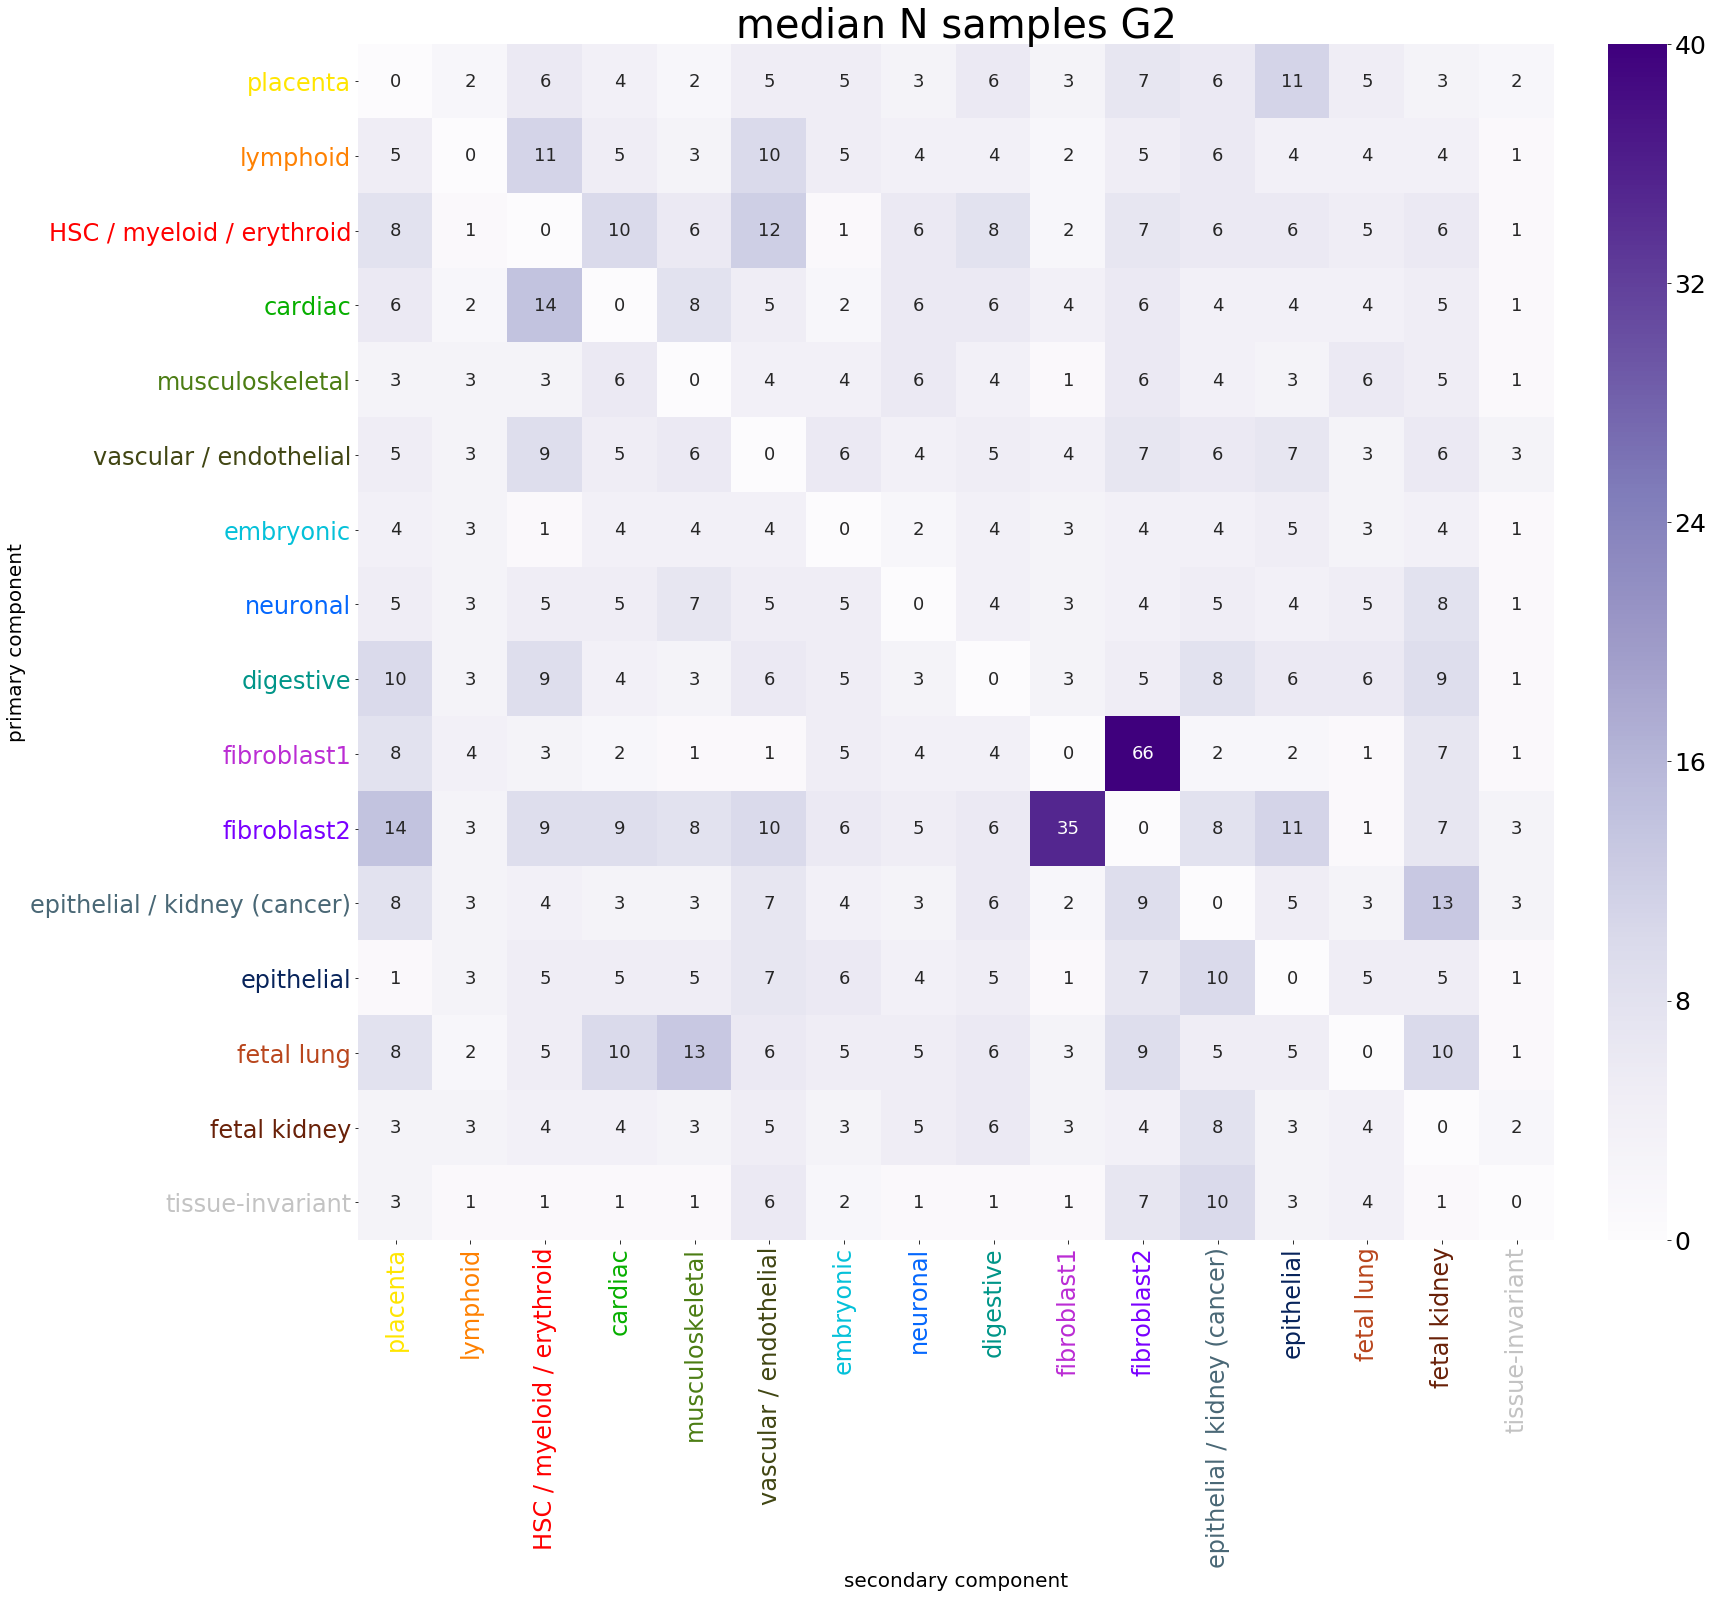

In [9]:
plt.figure(figsize = (24,22))
thing_to_heatmap = return_N_matrix(G2cut)
kox= sns.heatmap(thing_to_heatmap[strings_of_labels[WSO]].reindex(strings_of_labels[WSO]), annot=True, cmap='Purples', vmin=0,  vmax=40, fmt='d', cbar_kws={'fraction':0.046, 'pad':0.04}, annot_kws={'fontsize':18} )
ax =plt.gca()
kox.collections[0].colorbar.ax.tick_params(labelsize=25)
kox.set_aspect("equal")
the_fontsize=24
ax.set_ylabel('primary component',fontsize=20)    
ax.set_xlabel('secondary component', fontsize=20)
ax.get_xticklabels()
for n, i in enumerate(ax.get_xticklabels()):
    i.set_color(Comp_colors[WSO][n])
    i.set_fontsize(the_fontsize)
for n, i in enumerate(ax.get_yticklabels()):
    i.set_fontsize(the_fontsize)
    i.set_color(Comp_colors[WSO][n])
plt.title('median N samples G2', fontsize=40)

plt.savefig('22119_avgN_G2.pdf', transparent=True, bbox_inches='tight')
plt.show()
plt.close()

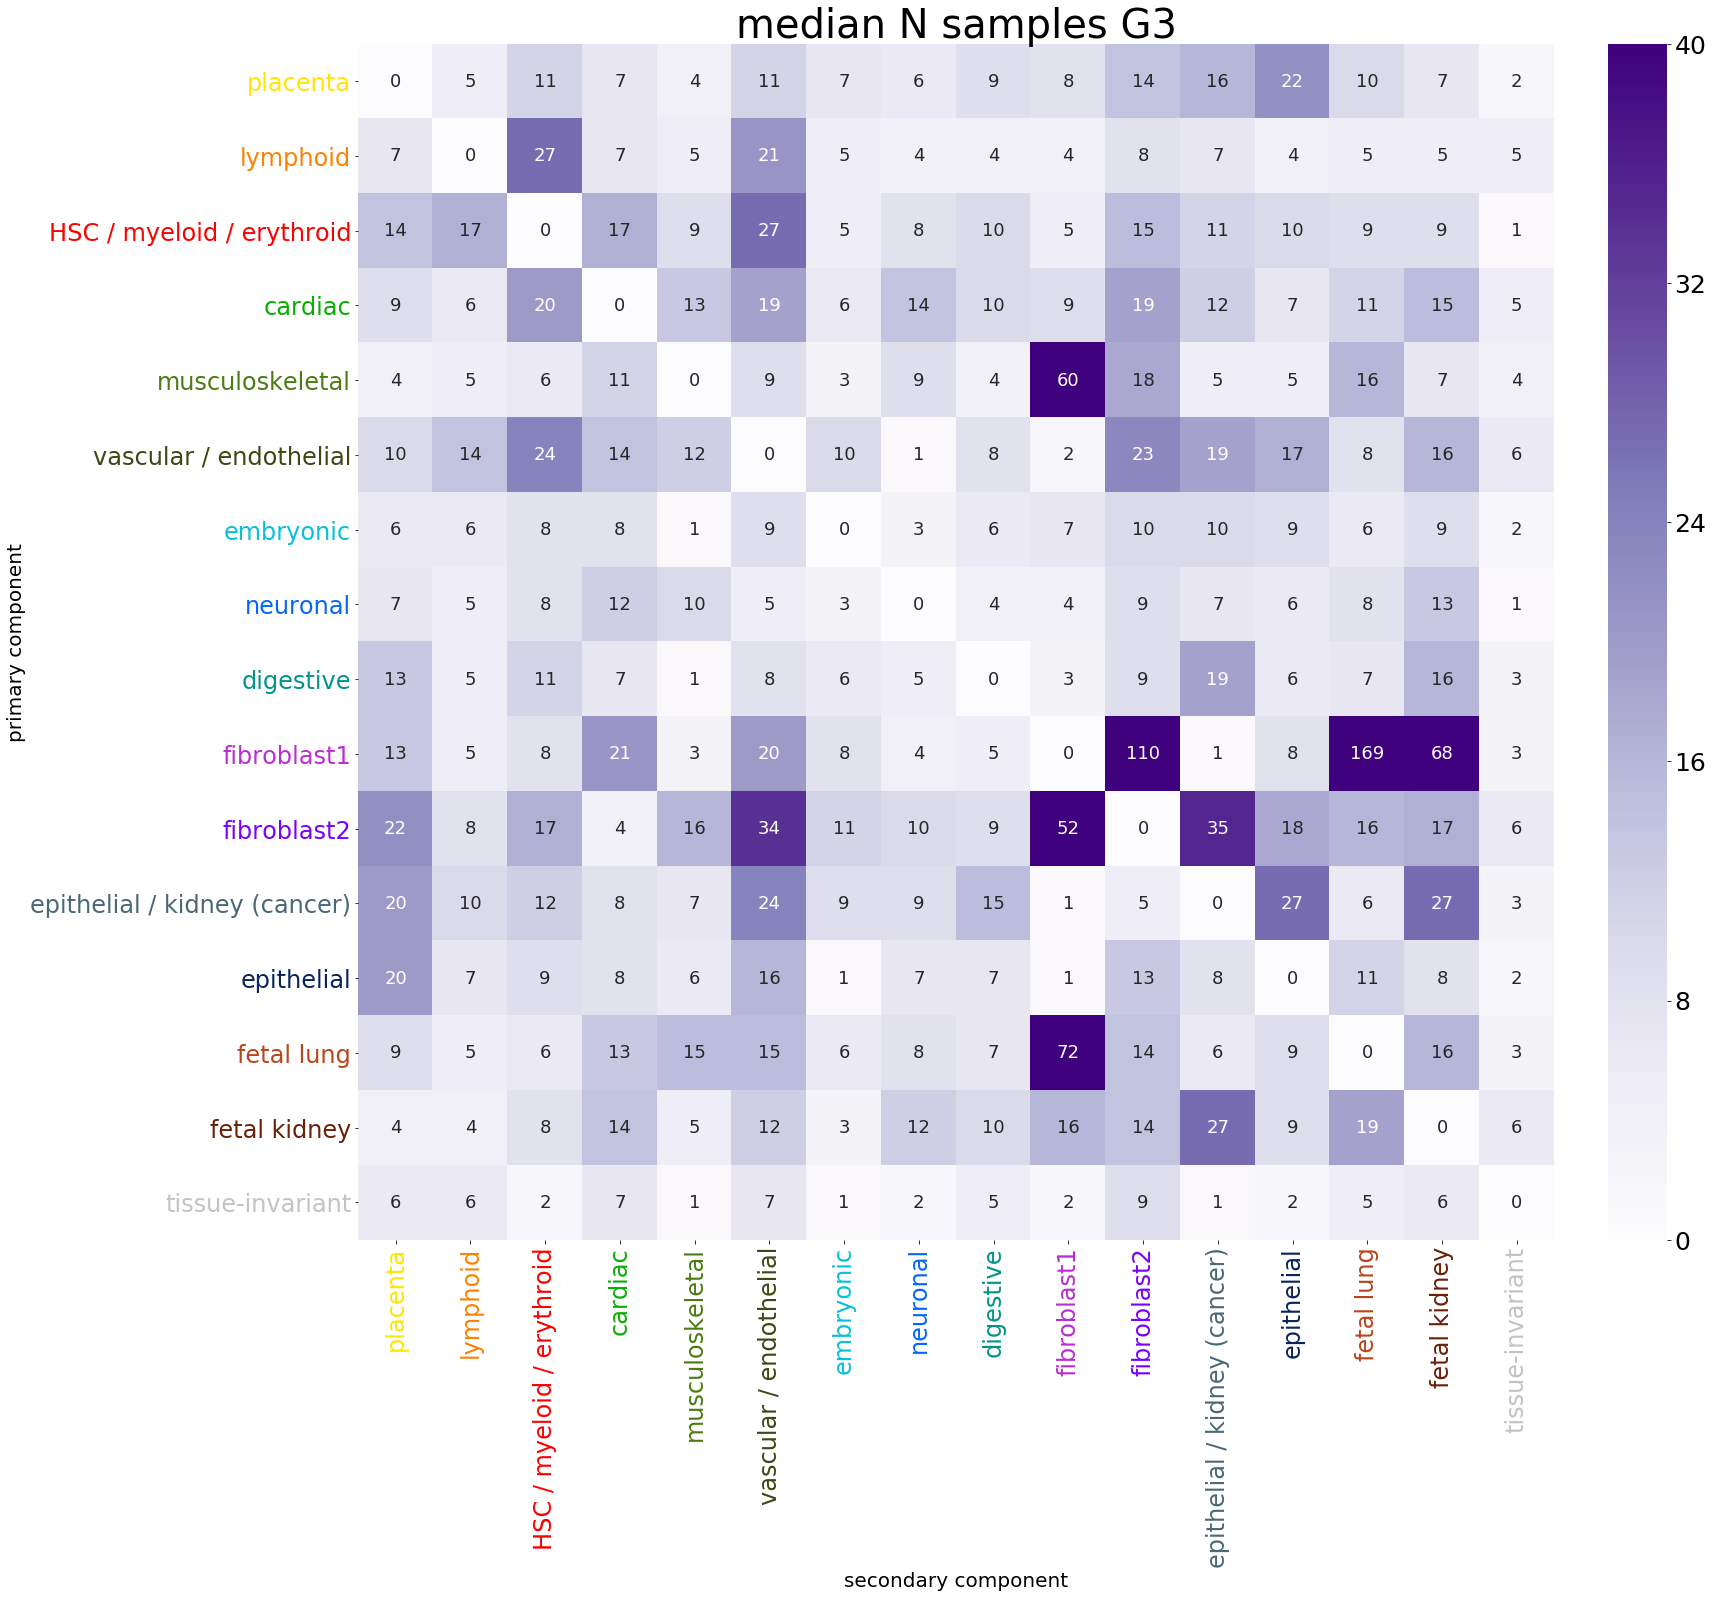

In [10]:
plt.figure(figsize = (24,22))
thing_to_heatmap = return_N_matrix(G3cut)
kox= sns.heatmap(thing_to_heatmap[strings_of_labels[WSO]].reindex(strings_of_labels[WSO]), annot=True, cmap='Purples', vmin=0, vmax=40, fmt='d', cbar_kws={'fraction':0.046, 'pad':0.04}, annot_kws={'fontsize':18} )
ax =plt.gca()
kox.collections[0].colorbar.ax.tick_params(labelsize=25)
kox.set_aspect("equal")
the_fontsize=24
ax.set_ylabel('primary component',fontsize=20)    
ax.set_xlabel('secondary component', fontsize=20)
ax.get_xticklabels()
for n, i in enumerate(ax.get_xticklabels()):
    i.set_color(Comp_colors[WSO][n])
    i.set_fontsize(the_fontsize)
for n, i in enumerate(ax.get_yticklabels()):
    i.set_fontsize(the_fontsize)
    i.set_color(Comp_colors[WSO][n])
plt.title('median N samples G3', fontsize=40)

plt.savefig('22119_avgN_G3.pdf', transparent=True, bbox_inches='tight')
plt.show()
plt.close()

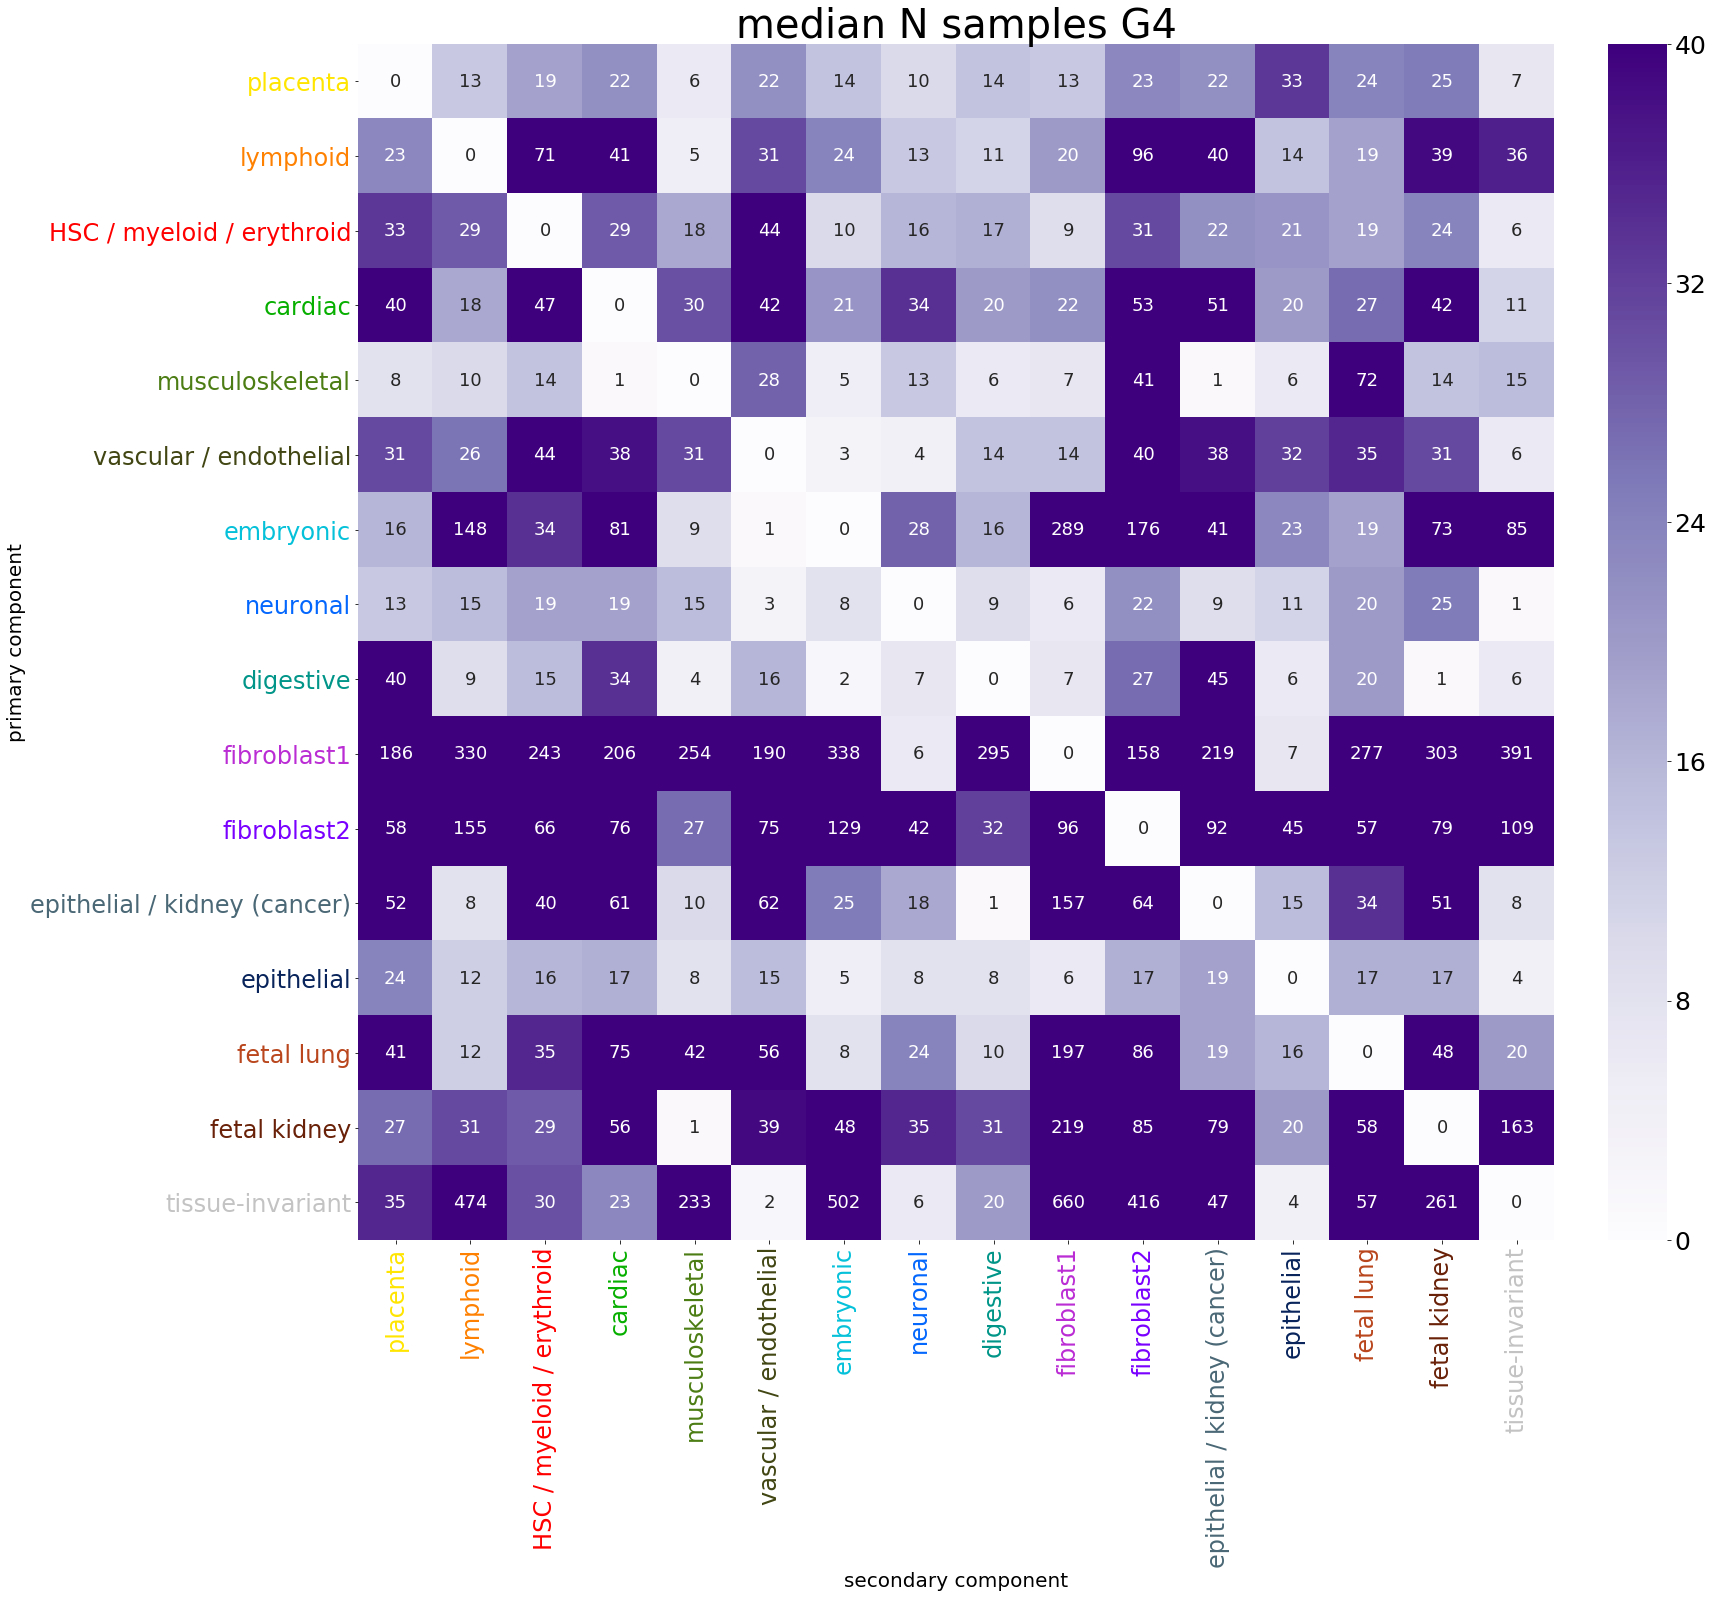

In [11]:
plt.figure(figsize = (24,22))
thing_to_heatmap = return_N_matrix(G4cut)
kox= sns.heatmap(thing_to_heatmap[strings_of_labels[WSO]].reindex(strings_of_labels[WSO]), annot=True, cmap='Purples', vmin=0,  vmax=40, fmt='d', cbar_kws={'fraction':0.046, 'pad':0.04}, annot_kws={'fontsize':18} )
ax =plt.gca()
kox.collections[0].colorbar.ax.tick_params(labelsize=25)
kox.set_aspect("equal")
the_fontsize=24
ax.set_ylabel('primary component',fontsize=20)    
ax.set_xlabel('secondary component', fontsize=20)
ax.get_xticklabels()
for n, i in enumerate(ax.get_xticklabels()):
    i.set_color(Comp_colors[WSO][n])
    i.set_fontsize(the_fontsize)
for n, i in enumerate(ax.get_yticklabels()):
    i.set_fontsize(the_fontsize)
    i.set_color(Comp_colors[WSO][n])
plt.title('median N samples G4', fontsize=40)

plt.savefig('22119_avgN_G4.pdf', transparent=True, bbox_inches='tight')
plt.show()
plt.close()

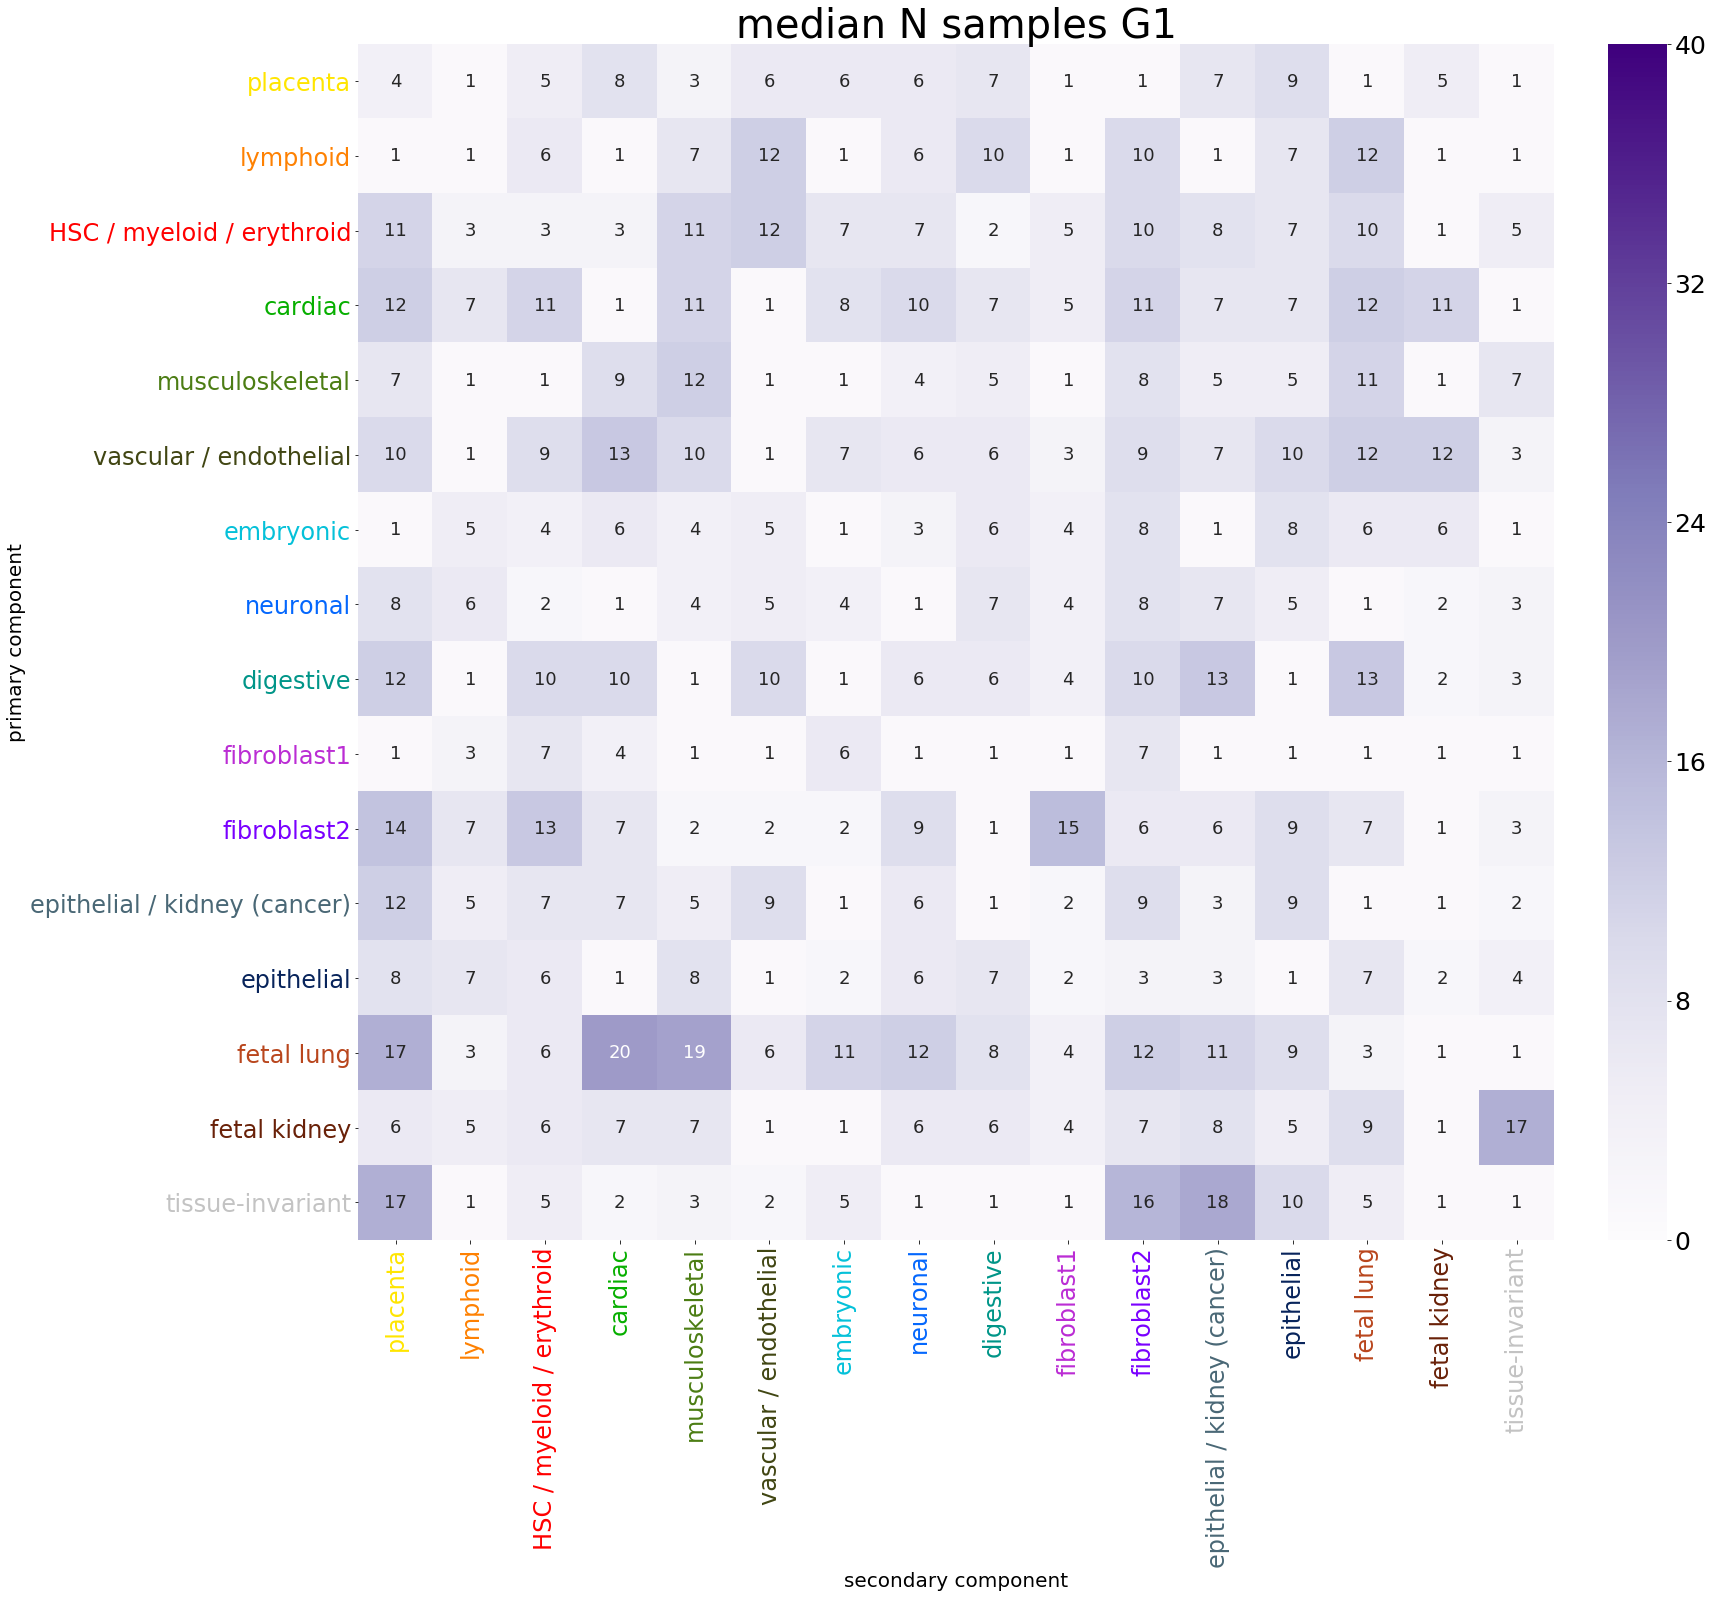

In [13]:
plt.figure(figsize = (24,22))
thing_to_heatmap = return_N_matrix(G1cut)
kox= sns.heatmap(thing_to_heatmap[strings_of_labels[WSO]].reindex(strings_of_labels[WSO]), annot=True, cmap='Purples', vmin=0,  vmax=40, fmt='d', cbar_kws={'fraction':0.046, 'pad':0.04}, annot_kws={'fontsize':18} )
ax =plt.gca()
kox.collections[0].colorbar.ax.tick_params(labelsize=25)
kox.set_aspect("equal")
the_fontsize=24
ax.set_ylabel('primary component',fontsize=20)    
ax.set_xlabel('secondary component', fontsize=20)
ax.get_xticklabels()
for n, i in enumerate(ax.get_xticklabels()):
    i.set_color(Comp_colors[WSO][n])
    i.set_fontsize(the_fontsize)
for n, i in enumerate(ax.get_yticklabels()):
    i.set_fontsize(the_fontsize)
    i.set_color(Comp_colors[WSO][n])
plt.title('median N samples G1', fontsize=40)

plt.savefig('22119_avgN_G1.pdf', transparent=True, bbox_inches='tight')
plt.show()
plt.close()

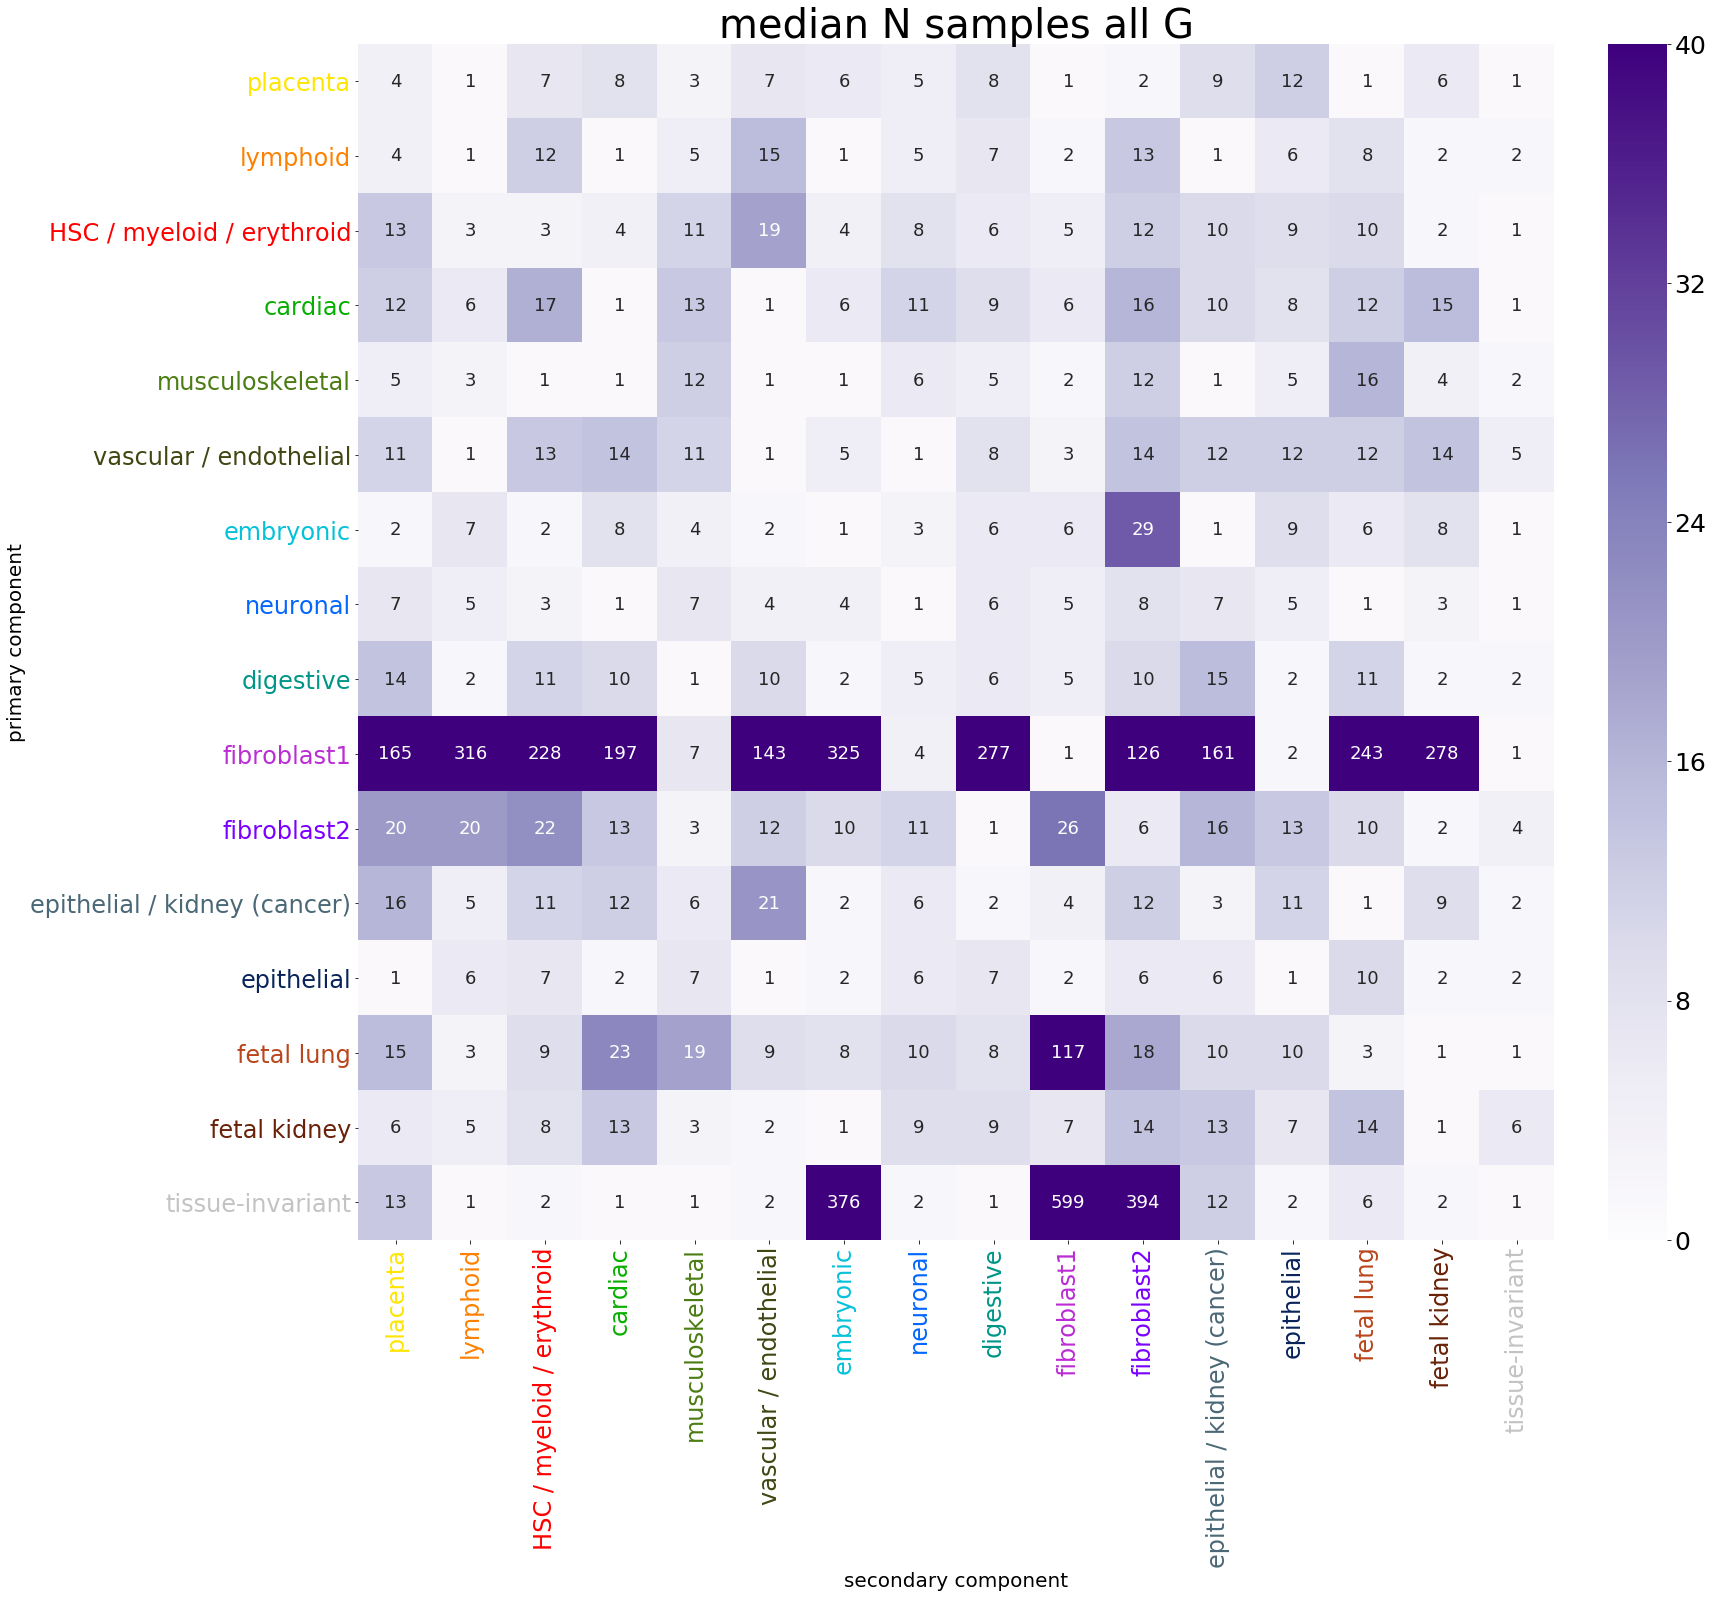

In [20]:
plt.figure(figsize = (24,22))
thing_to_heatmap = return_N_matrix(maxcolor>-1)
kox= sns.heatmap(thing_to_heatmap[strings_of_labels[WSO]].reindex(strings_of_labels[WSO]), annot=True, cmap='Purples', vmin=0, vmax=40, fmt='d', cbar_kws={'fraction':0.046, 'pad':0.04}, annot_kws={'fontsize':18} )
ax =plt.gca()
kox.collections[0].colorbar.ax.tick_params(labelsize=25)
kox.set_aspect("equal")
the_fontsize=24
ax.set_ylabel('primary component',fontsize=20)    
ax.set_xlabel('secondary component', fontsize=20)
ax.get_xticklabels()
for n, i in enumerate(ax.get_xticklabels()):
    i.set_color(Comp_colors[WSO][n])
    i.set_fontsize(the_fontsize)
for n, i in enumerate(ax.get_yticklabels()):
    i.set_fontsize(the_fontsize)
    i.set_color(Comp_colors[WSO][n])
plt.title('median N samples all G', fontsize=40)

plt.savefig('22119_avgN_allG.pdf', transparent=True, bbox_inches='tight')
plt.show()
plt.close()

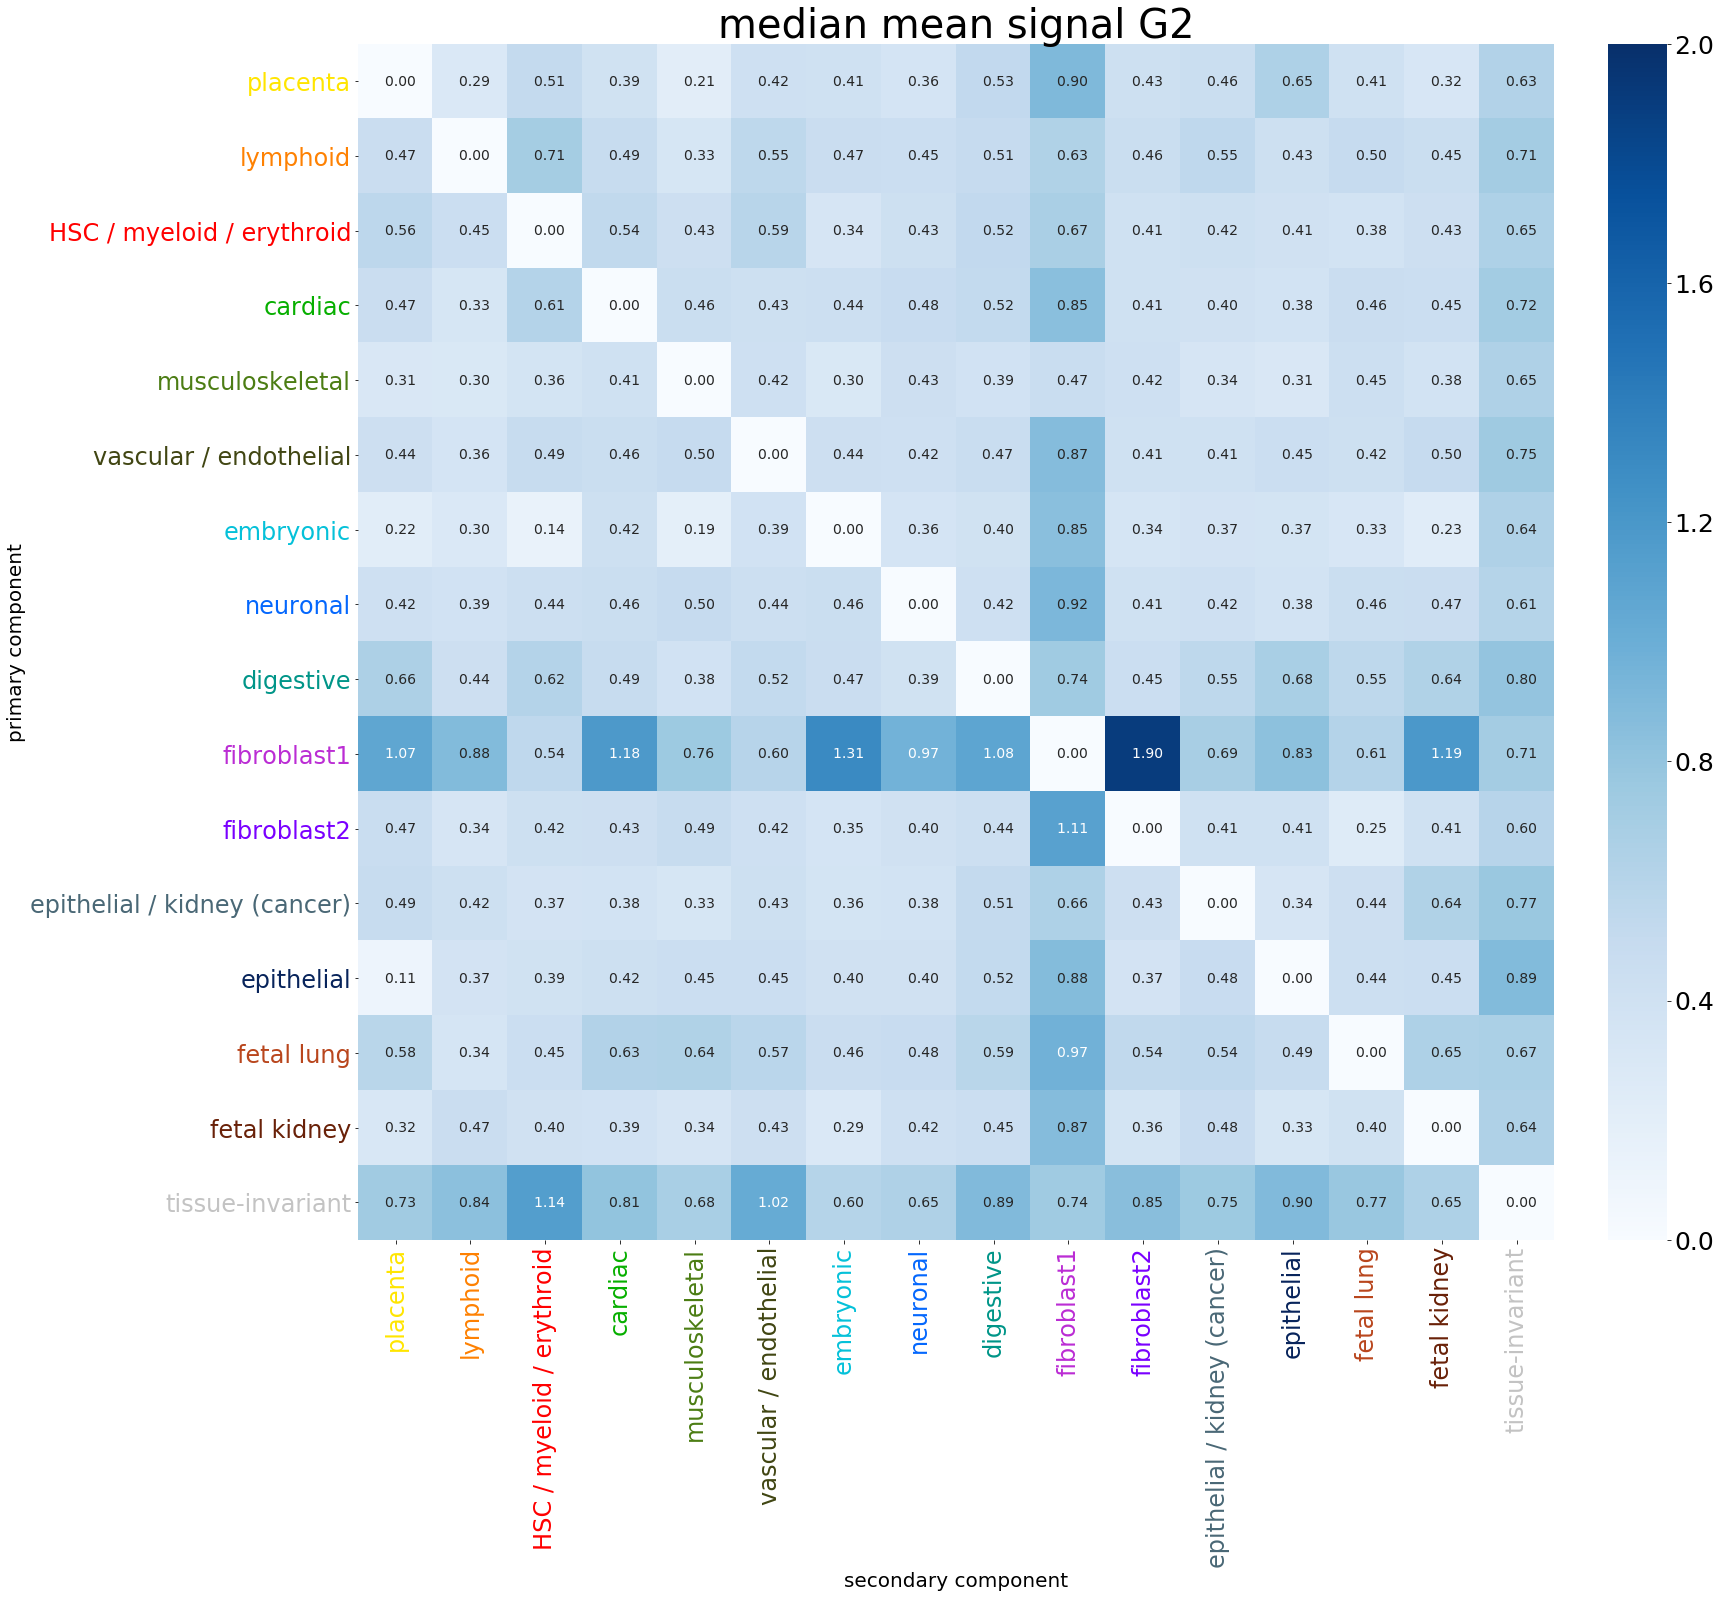

In [15]:
plt.figure(figsize = (24,22))
thing_to_heatmap = return_mediansignal_matrix(G2cut)
kox= sns.heatmap(thing_to_heatmap[strings_of_labels[WSO]].reindex(strings_of_labels[WSO]), annot=True, cmap='Blues', vmin=0, vmax=2, fmt='6.2f', cbar_kws={'fraction':0.046, 'pad':0.04}, annot_kws={'fontsize':14} )
ax =plt.gca()
kox.collections[0].colorbar.ax.tick_params(labelsize=25)
kox.set_aspect("equal")
the_fontsize=24
ax.set_ylabel('primary component',fontsize=20)    
ax.set_xlabel('secondary component', fontsize=20)
ax.get_xticklabels()
for n, i in enumerate(ax.get_xticklabels()):
    i.set_color(Comp_colors[WSO][n])
    i.set_fontsize(the_fontsize)
for n, i in enumerate(ax.get_yticklabels()):
    i.set_fontsize(the_fontsize)
    i.set_color(Comp_colors[WSO][n])
plt.title('median mean signal G2', fontsize=40)

plt.savefig('22119_mediansignal_G2.pdf', transparent=True, bbox_inches='tight')
plt.show()
plt.close()

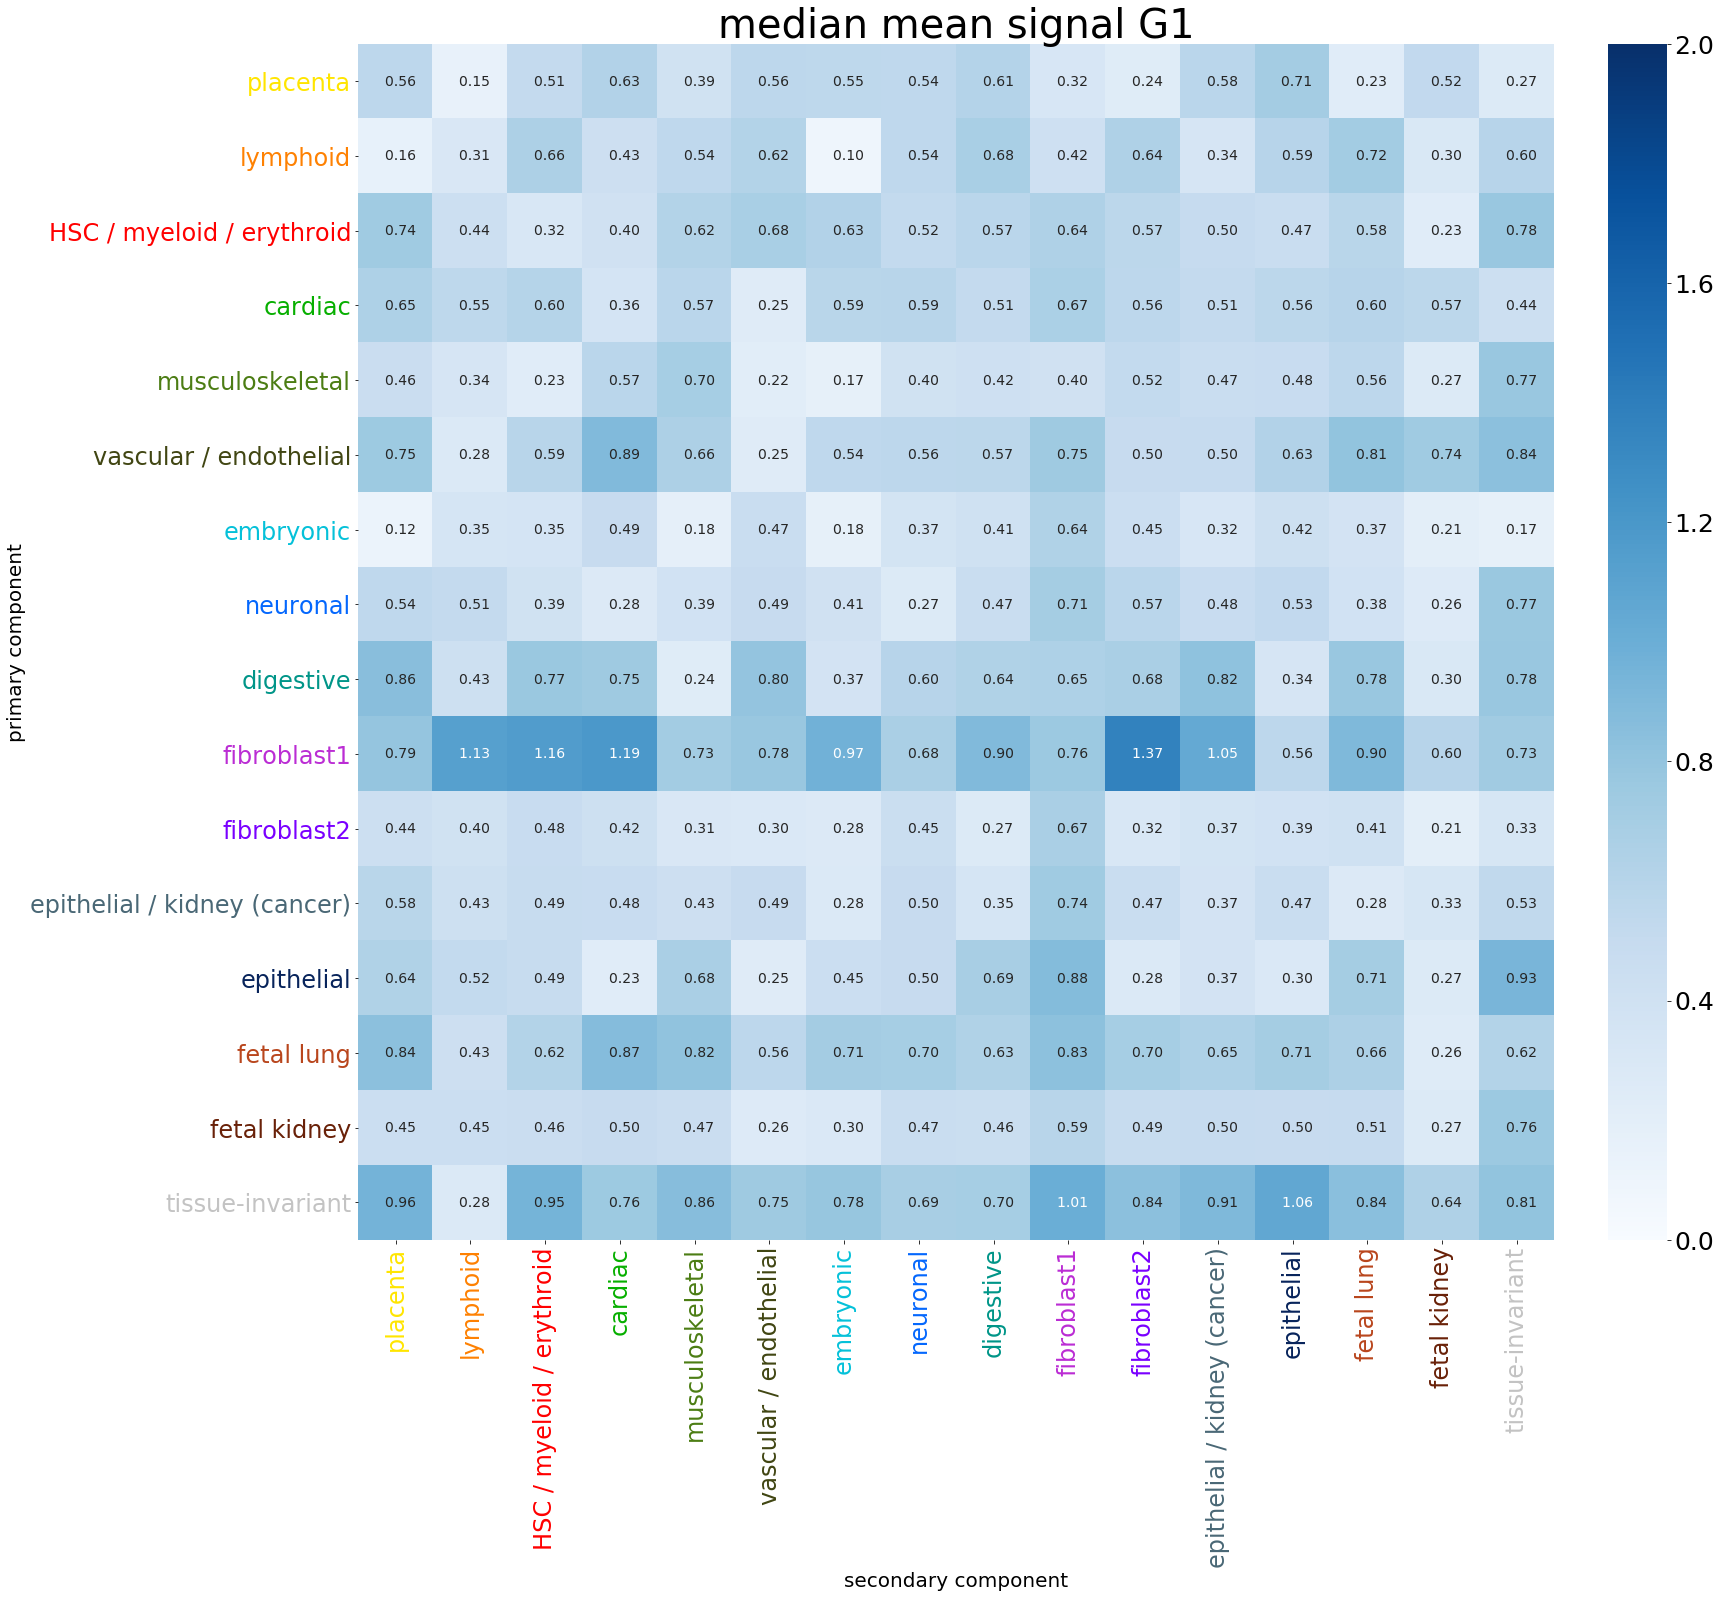

In [16]:
plt.figure(figsize = (24,22))
thing_to_heatmap = return_mediansignal_matrix(G1cut)
kox= sns.heatmap(thing_to_heatmap[strings_of_labels[WSO]].reindex(strings_of_labels[WSO]), annot=True, cmap='Blues', vmin=0, vmax=2, fmt='6.2f', cbar_kws={'fraction':0.046, 'pad':0.04}, annot_kws={'fontsize':14} )
ax =plt.gca()
kox.collections[0].colorbar.ax.tick_params(labelsize=25)
kox.set_aspect("equal")
the_fontsize=24
ax.set_ylabel('primary component',fontsize=20)    
ax.set_xlabel('secondary component', fontsize=20)
ax.get_xticklabels()
for n, i in enumerate(ax.get_xticklabels()):
    i.set_color(Comp_colors[WSO][n])
    i.set_fontsize(the_fontsize)
for n, i in enumerate(ax.get_yticklabels()):
    i.set_fontsize(the_fontsize)
    i.set_color(Comp_colors[WSO][n])
plt.title('median mean signal G1', fontsize=40)

plt.savefig('22119_mediansignal_G1.pdf', transparent=True, bbox_inches='tight')
plt.show()
plt.close()

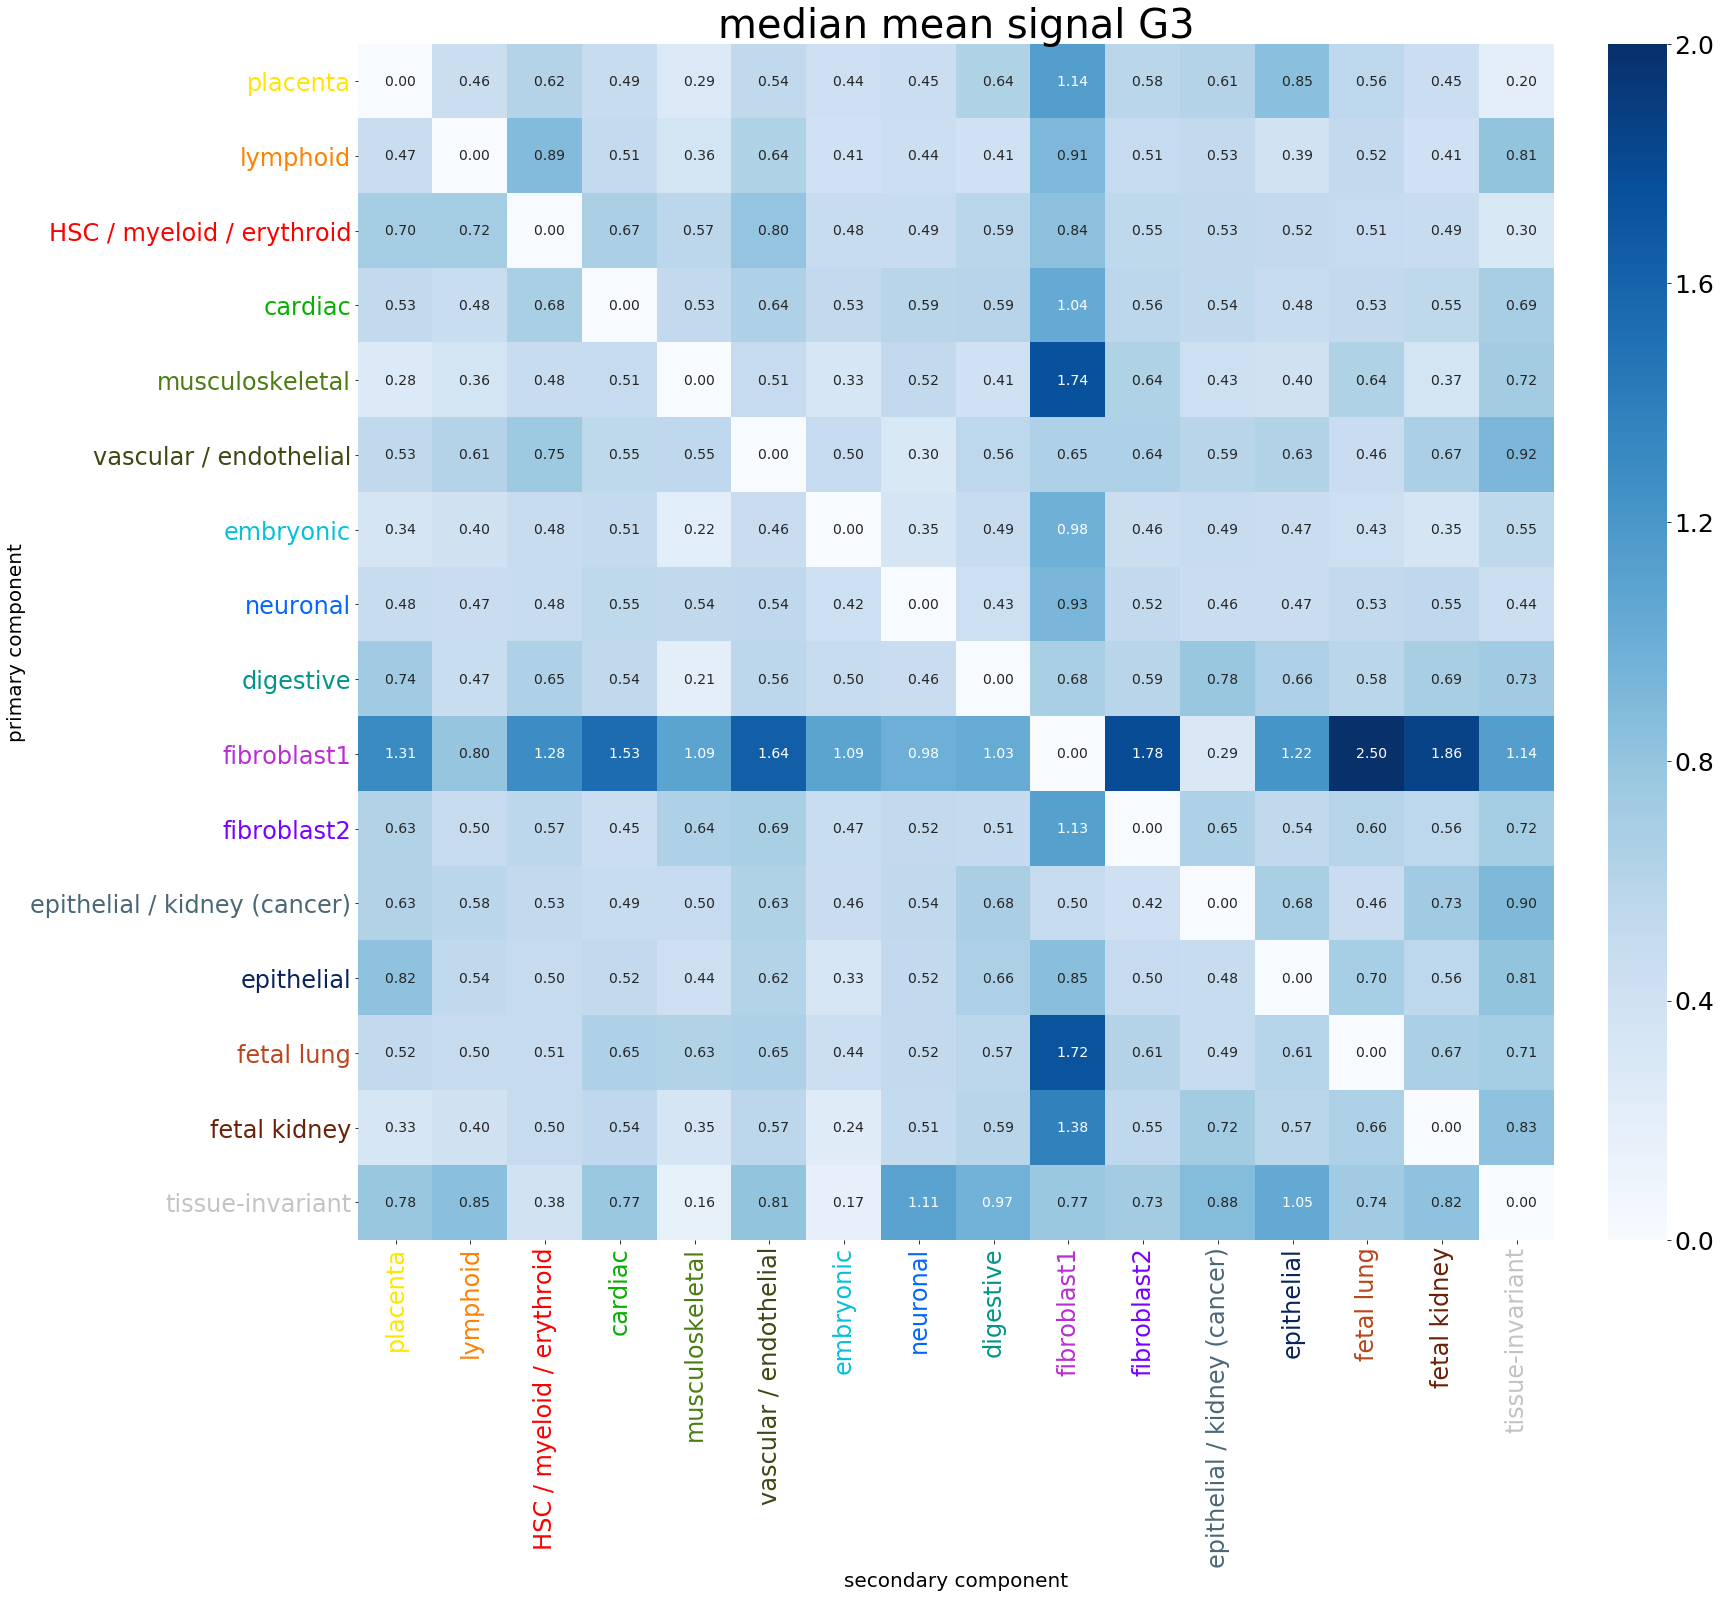

In [17]:
plt.figure(figsize = (24,22))
thing_to_heatmap = return_mediansignal_matrix(G3cut)
kox= sns.heatmap(thing_to_heatmap[strings_of_labels[WSO]].reindex(strings_of_labels[WSO]), annot=True, cmap='Blues', vmin=0, vmax=2, fmt='6.2f', cbar_kws={'fraction':0.046, 'pad':0.04}, annot_kws={'fontsize':14} )
ax =plt.gca()
kox.collections[0].colorbar.ax.tick_params(labelsize=25)
kox.set_aspect("equal")
the_fontsize=24
ax.set_ylabel('primary component',fontsize=20)    
ax.set_xlabel('secondary component', fontsize=20)
ax.get_xticklabels()
for n, i in enumerate(ax.get_xticklabels()):
    i.set_color(Comp_colors[WSO][n])
    i.set_fontsize(the_fontsize)
for n, i in enumerate(ax.get_yticklabels()):
    i.set_fontsize(the_fontsize)
    i.set_color(Comp_colors[WSO][n])
plt.title('median mean signal G3', fontsize=40)

plt.savefig('22119_mediansignal_G3.pdf', transparent=True, bbox_inches='tight')
plt.show()
plt.close()

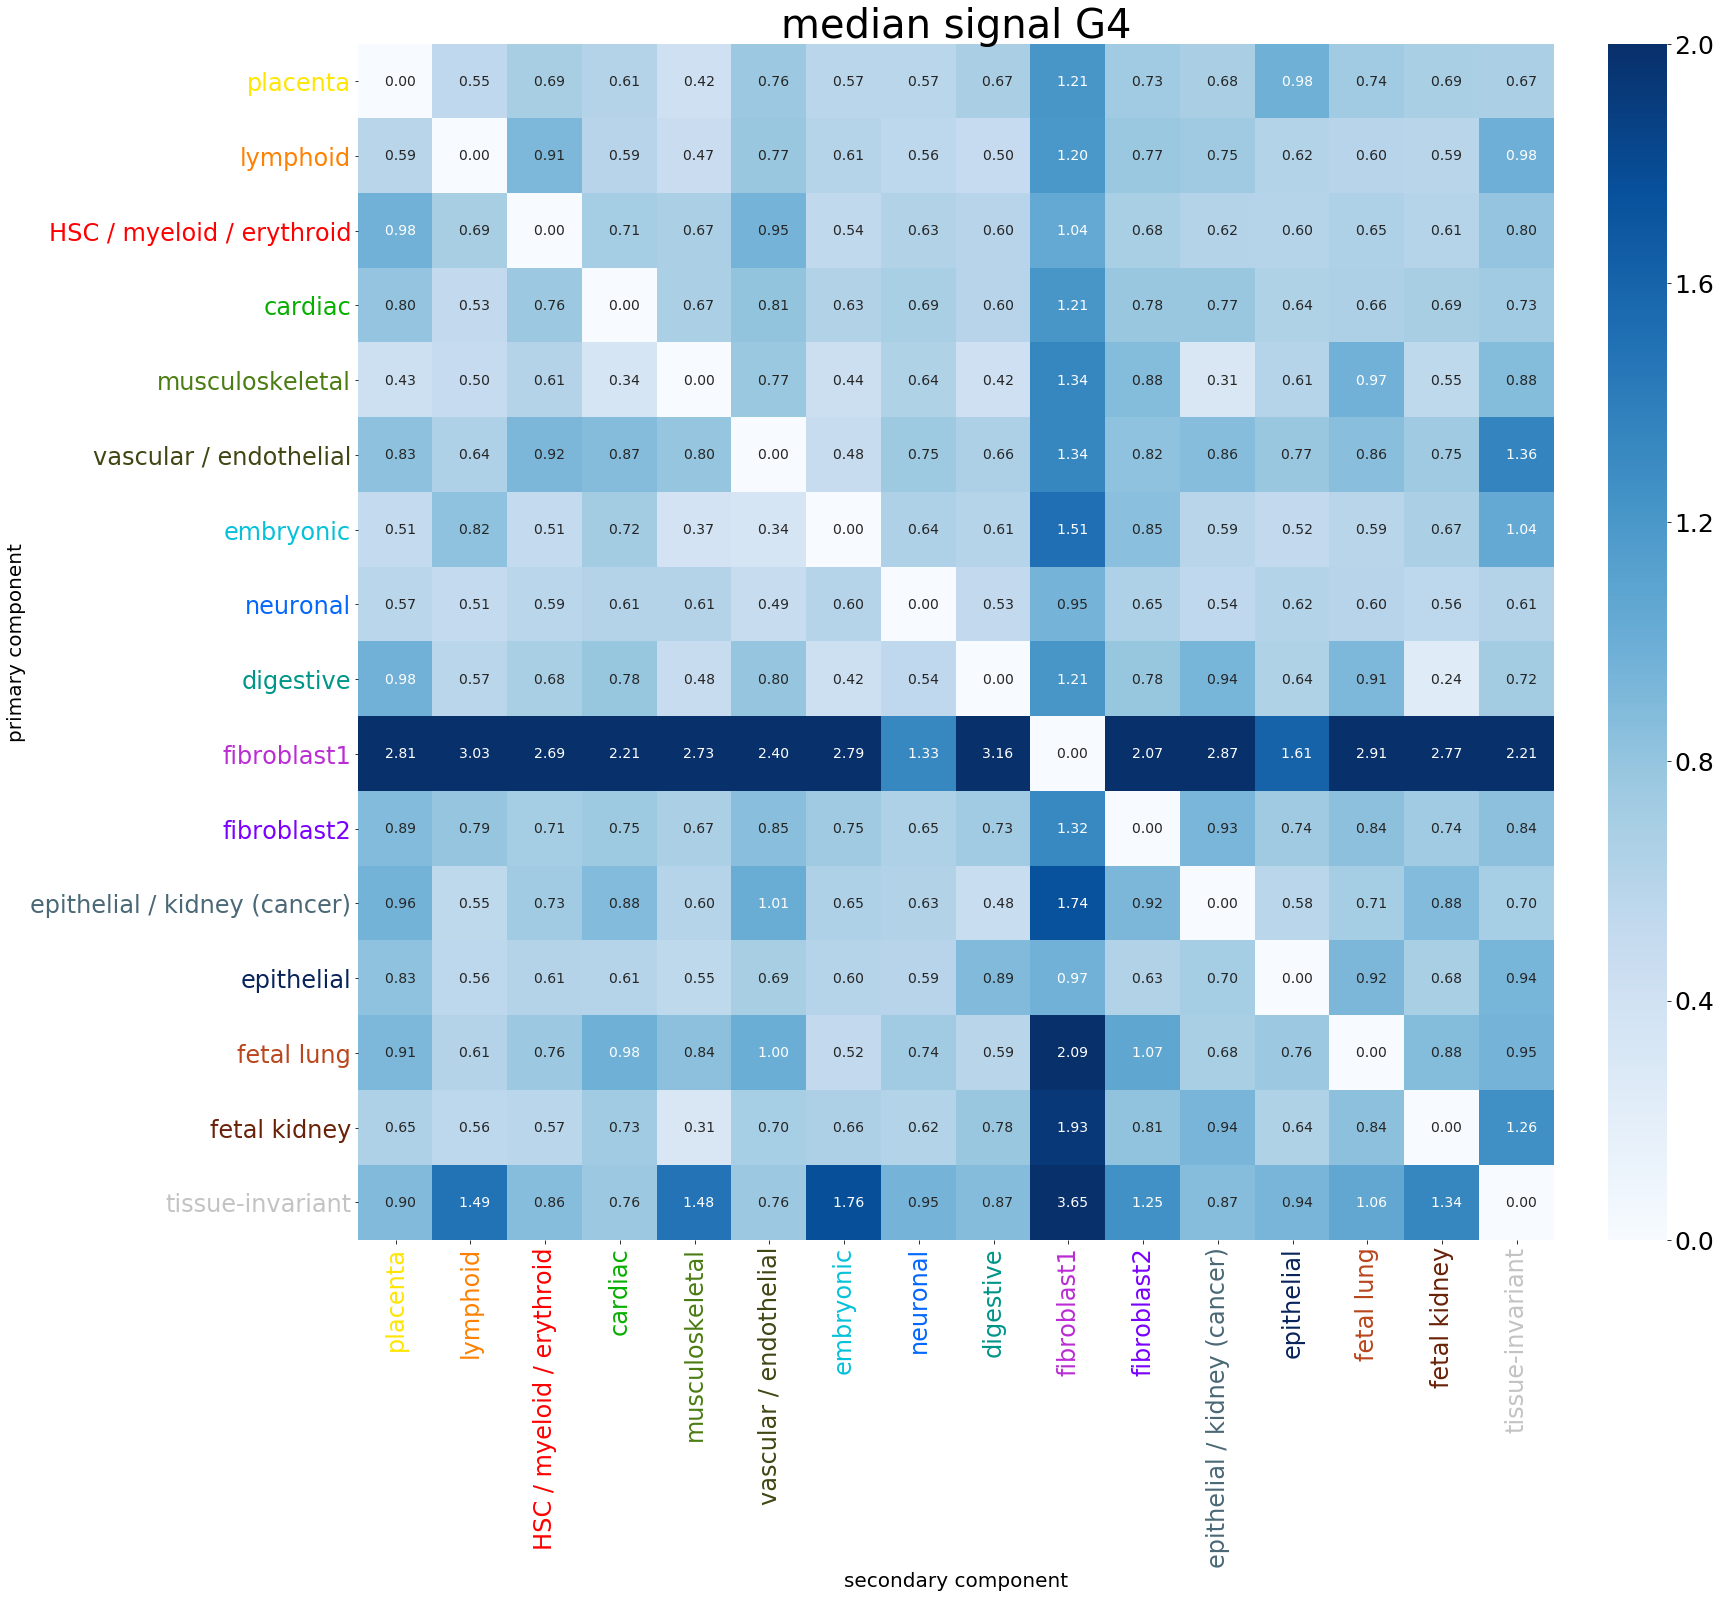

In [18]:
plt.figure(figsize = (24,22))
thing_to_heatmap = return_mediansignal_matrix(G4cut)
kox= sns.heatmap(thing_to_heatmap[strings_of_labels[WSO]].reindex(strings_of_labels[WSO]), annot=True, cmap='Blues', vmin=0, vmax=2, fmt='6.2f', cbar_kws={'fraction':0.046, 'pad':0.04}, annot_kws={'fontsize':14} )
ax =plt.gca()
kox.collections[0].colorbar.ax.tick_params(labelsize=25)
kox.set_aspect("equal")
the_fontsize=24
ax.set_ylabel('primary component',fontsize=20)    
ax.set_xlabel('secondary component', fontsize=20)
ax.get_xticklabels()
for n, i in enumerate(ax.get_xticklabels()):
    i.set_color(Comp_colors[WSO][n])
    i.set_fontsize(the_fontsize)
for n, i in enumerate(ax.get_yticklabels()):
    i.set_fontsize(the_fontsize)
    i.set_color(Comp_colors[WSO][n])
plt.title('median signal G4', fontsize=40)

plt.savefig('22119_mediansignal_G4.pdf', transparent=True, bbox_inches='tight')
plt.show()
plt.close()

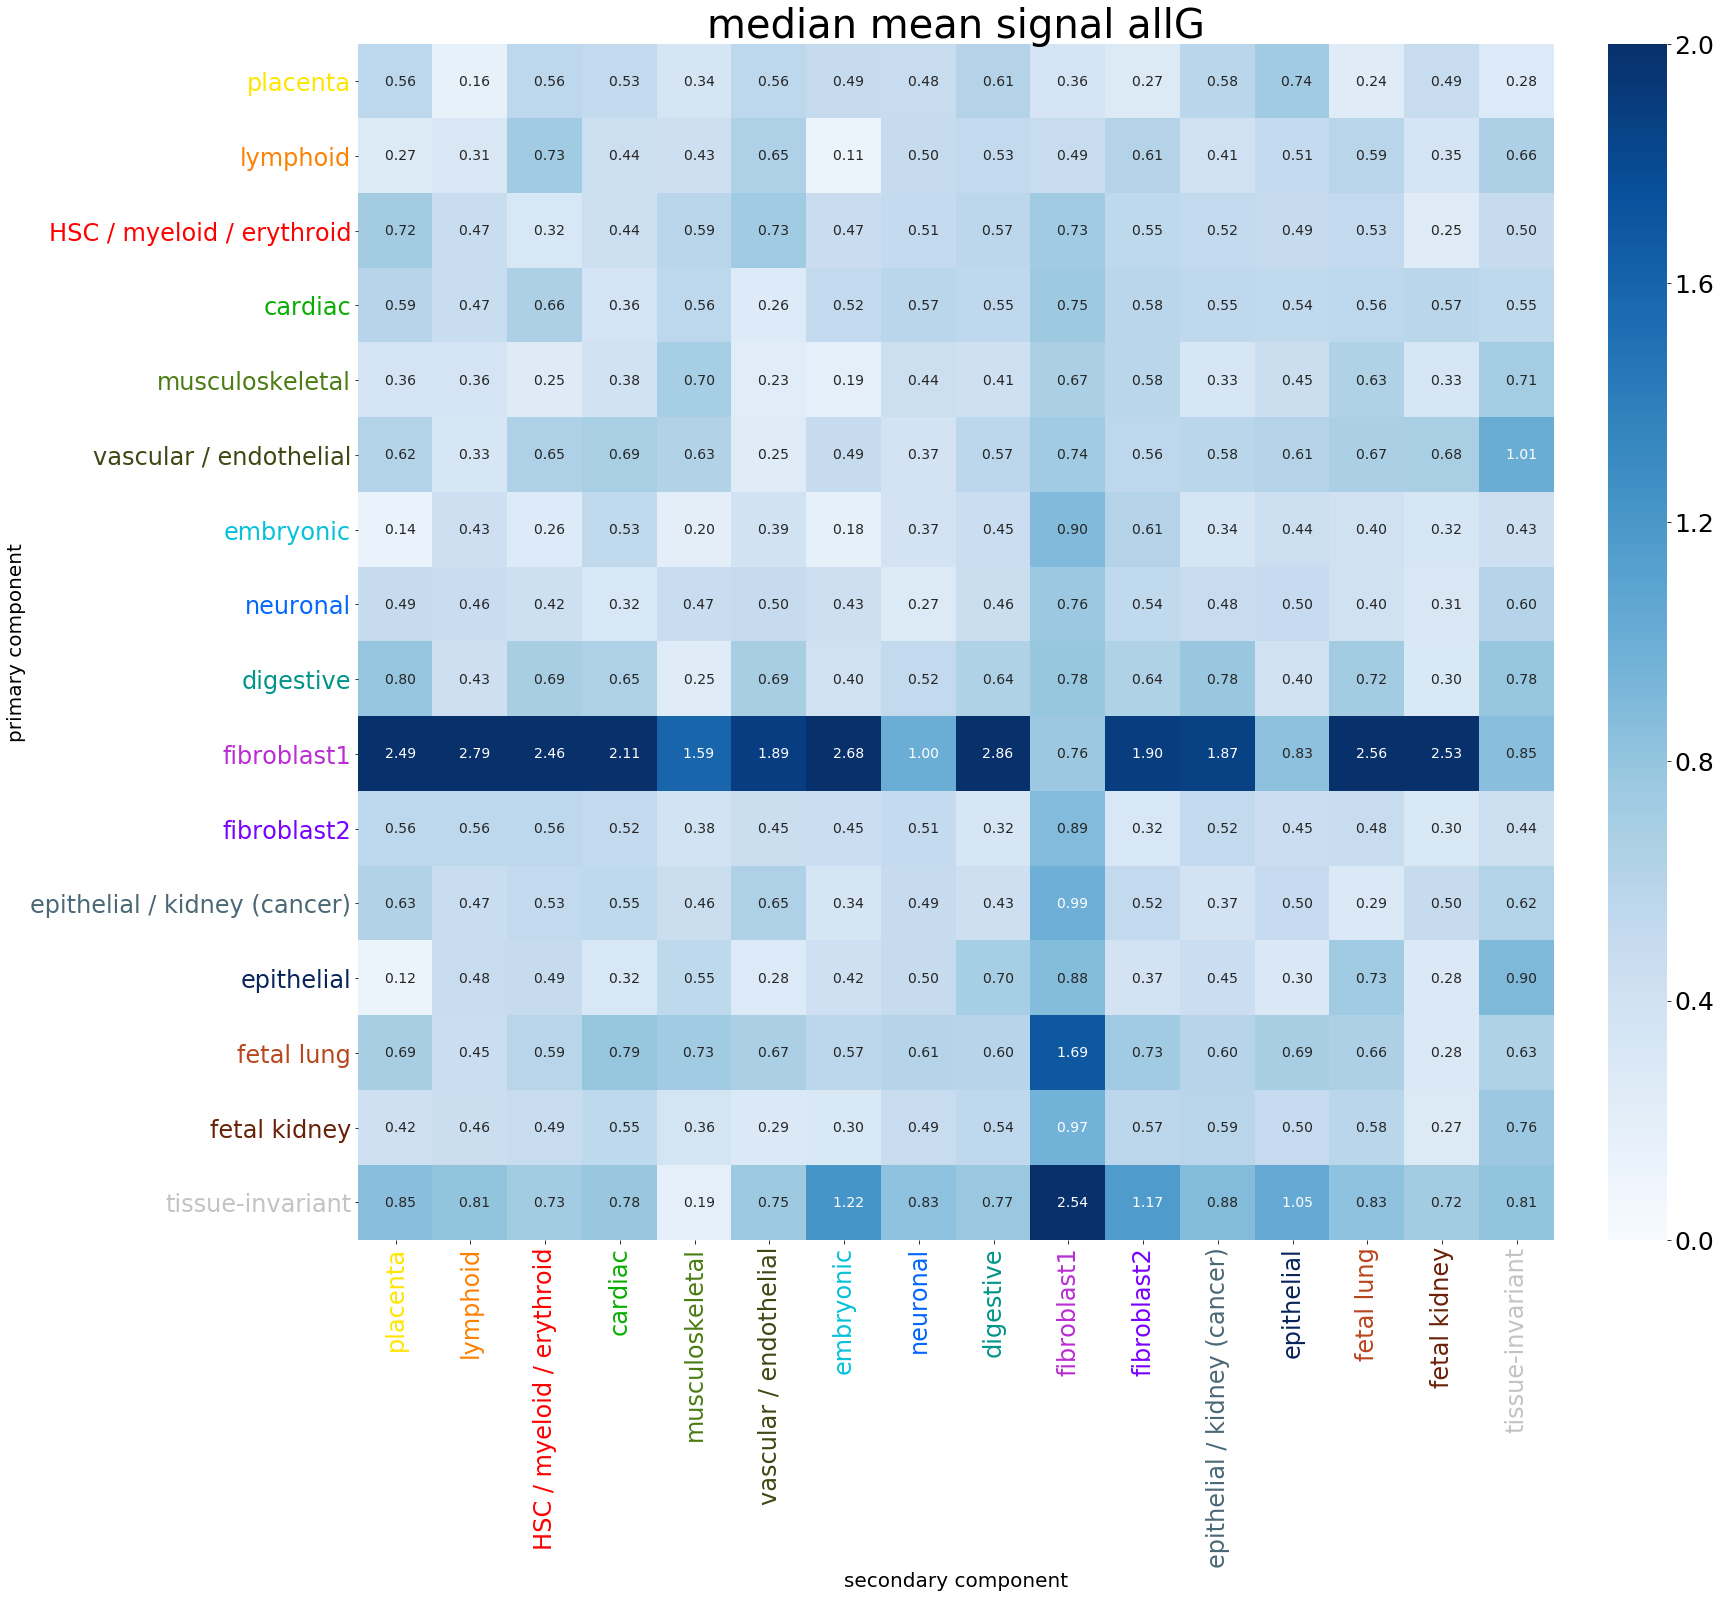

In [19]:
plt.figure(figsize = (24,22))
thing_to_heatmap = return_mediansignal_matrix(maxcolor>-1)
kox= sns.heatmap(thing_to_heatmap[strings_of_labels[WSO]].reindex(strings_of_labels[WSO]), annot=True, cmap='Blues', vmin=0, vmax=2, fmt='6.2f', cbar_kws={'fraction':0.046, 'pad':0.04}, annot_kws={'fontsize':14} )
ax =plt.gca()
kox.collections[0].colorbar.ax.tick_params(labelsize=25)
kox.set_aspect("equal")
the_fontsize=24
ax.set_ylabel('primary component',fontsize=20)    
ax.set_xlabel('secondary component', fontsize=20)
ax.get_xticklabels()
for n, i in enumerate(ax.get_xticklabels()):
    i.set_color(Comp_colors[WSO][n])
    i.set_fontsize(the_fontsize)
for n, i in enumerate(ax.get_yticklabels()):
    i.set_fontsize(the_fontsize)
    i.set_color(Comp_colors[WSO][n])
plt.title('median mean signal allG', fontsize=40)

plt.savefig('22119_mediansignal_allG.pdf', transparent=True, bbox_inches='tight')
plt.show()
plt.close()